In [1]:
from ultralytics import YOLO
from collections import Counter
import os
import cv2
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import random

## Data Processing

In [38]:
def load_class_names(label_folder):

    classes_file = os.path.join(label_folder, "classes.txt")
    if not os.path.exists(classes_file):
        print(f"{classes_file} file not exists!")
        return {}

    with open(classes_file, "r", encoding="utf-8") as f:
        class_names = [line.strip() for line in f.readlines()]
    
    return {i: class_names[i] for i in range(len(class_names))}



def count_labels(label_folder):

    category_count = Counter()

    for label_file in os.listdir(label_folder):
        if label_file.endswith(".txt") and label_file != "classes.txt":
            with open(os.path.join(label_folder, label_file), "r", encoding="utf-8") as f:
                for line in f:
                    class_id = int(line.split()[0]) 
                    category_count[class_id] += 1 

    return category_count

datasets = ["train", "test", "val"]
base_path = "final_datasets/label"


for dataset in datasets:
    label_folder = os.path.join(base_path, dataset)
    class_map = load_class_names(label_folder)
    counts = count_labels(label_folder)

    print(f"\n {dataset.upper()} dataset:")
    
    for class_id in sorted(class_map.keys()):
        class_name = class_map.get(class_id, f"class {class_id}")
        count = counts.get(class_id, 0)
        print(f"{class_name} (class {class_id}): {count}")



 TRAIN dataset:
Large crater (class 0): 33
Small crater (class 1): 1502
Medium crater (class 2): 128
Incomplete crater (class 3): 121

 TEST dataset:
Large crater (class 0): 17
Small crater (class 1): 722
Medium crater (class 2): 38
Incomplete crater (class 3): 66

 VAL dataset:
Large crater (class 0): 6
Small crater (class 1): 351
Medium crater (class 2): 13
Incomplete crater (class 3): 34


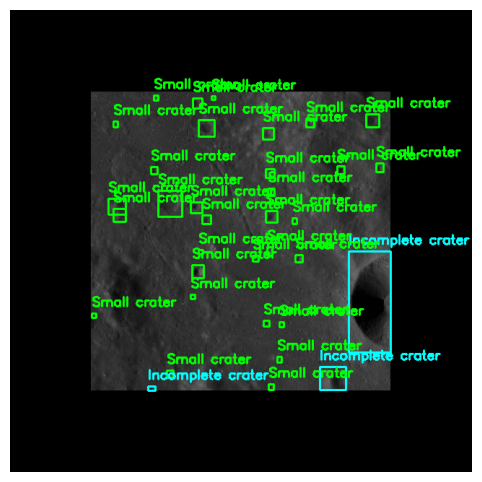

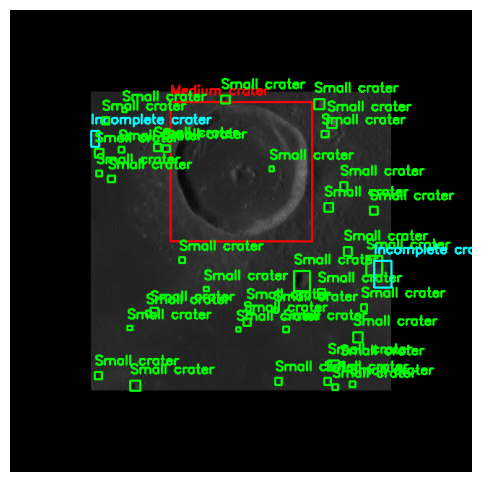

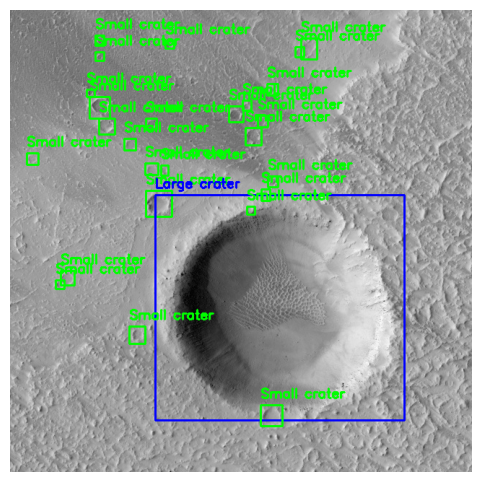

In [41]:
def visualize_annotations(image_path, label_path, class_map, class_colors):
    """
    Draw bounding boxes on images based on YOLO labels.
    """
    image = cv2.imread(image_path)
    h, w, _ = image.shape

    if not os.path.exists(label_path):
        print(f"⚠️ No label found for {image_path}")
        return
    
    with open(label_path, "r", encoding="utf-8") as f:
        for line in f:
            parts = line.strip().split()
            class_id = int(parts[0])
            x_center, y_center, box_w, box_h = map(float, parts[1:])
            
            x1 = int((x_center - box_w / 2) * w)
            y1 = int((y_center - box_h / 2) * h)
            x2 = int((x_center + box_w / 2) * w)
            y2 = int((y_center + box_h / 2) * h)

            label = class_map.get(class_id, f"Class {class_id}")
            color = class_colors.get(class_id, (255, 255, 255))  # Default to white if missing

            cv2.rectangle(image, (x1, y1), (x2, y2), color, 2)
            cv2.putText(image, label, (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.6, color, 2)

    plt.figure(figsize=(10, 6))
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.axis("off")
    plt.show()

# Define dataset path
dataset_path = "final_datasets"
subset = "train"  # Change to 'test' or 'val' to visualize other sets

# Get paths
image_folder = os.path.join(dataset_path, "image", subset)
label_folder = os.path.join(dataset_path, "label", subset)

# Load class names
class_map = load_class_names(label_folder)

# Assign distinct colors to each class
class_colors = {
    0: (255, 0, 0),   # Large crater - Red
    1: (0, 255, 0),   # Small crater - Green
    2: (0, 0, 255),   # Medium crater - Blue
    3: (255, 255, 0)  # Incomplete crater - Yellow
}

# Get a list of image files (limit to first 3)
image_files = [f for f in os.listdir(image_folder) if f.endswith(".jpg")][:3]

if not image_files:
    print("⚠️ No images found in the dataset!")
else:
    for image_file in image_files:
        image_path = os.path.join(image_folder, image_file)
        label_path = os.path.join(label_folder, image_file.replace(".jpg", ".txt"))
        visualize_annotations(image_path, label_path, class_map, class_colors)


In [47]:
import pandas as pd
import plotly.express as px
import plotly.io as pio
pio.templates.default = "plotly"  # 使用默认的浅蓝色背景

class_name_map = {
    0: "Large Crater",
    1: "Small Crater",
    2: "Medium Crater",
    3: "Incomplete Crater"
}

color_map = {
    "Large Crater": "orange",
    "Small Crater": "blue",
    "Medium Crater": "red",
    "Incomplete Crater": "green"
}

class_order = ["Large Crater", "Small Crater", "Medium Crater", "Incomplete Crater"]

def get_bounding_box_data(label_folder):

    data = []

    for label_file in os.listdir(label_folder):
        if label_file.endswith(".txt") and label_file != "classes.txt":
            with open(os.path.join(label_folder, label_file), "r", encoding="utf-8") as f:
                for line in f:
                    parts = line.strip().split()
                    class_id = int(parts[0])
                    box_w, box_h = map(float, parts[3:5])
                    area = box_w * box_h
                    data.append({"class": class_name_map[class_id], "area": area})

    return pd.DataFrame(data)

dataset_path = "final_datasets"
train_labels_df = get_bounding_box_data(os.path.join(dataset_path, "label", "train"))
val_labels_df = get_bounding_box_data(os.path.join(dataset_path, "label", "val"))

def plot_bounding_box_distribution(labels_df, title):

    if labels_df.empty:
        print(f"No bounding box data available for {title}")
        return

    fig = px.histogram(
        labels_df, 
        x='area', 
        nbins=50, 
        title=title, 
        color='class',
        category_orders={"class": class_order},
        color_discrete_map=color_map
    )
    fig.show()

plot_bounding_box_distribution(train_labels_df, "Train Bounding Box Area Distribution")
plot_bounding_box_distribution(val_labels_df, "Validation Bounding Box Area Distribution")


In [49]:
# def filter_small_craters(labels_df,classes):
#     if classes == 0:
#         return labels_df[labels_df["class"] == "Large Crater"]
#     if classes == 1:
#         return labels_df[labels_df["class"] == "Small Crater"]
#     if classes == 2:
#         return labels_df[labels_df["class"] == "Medium Crater"]
#     if classes == 3:
#         return labels_df[labels_df["class"] == "Incomplete Crater"]
# 
# def plot_crater_distribution(labels_df, title, classes):
#     small_craters_df = filter_small_craters(labels_df, classes)
# 
#     if small_craters_df.empty:
#         print(f"No bounding box data available for {title}")
#         return
# 
#     fig = px.histogram(
#         small_craters_df, 
#         x='area', 
#         nbins=50, 
#         title=title, 
#         color='class',
#         color_discrete_map=color_map
#     )
#     fig.show()
# 
# plot_crater_distribution(train_labels_df, "Train Large Crater Area Distribution",0)
# plot_crater_distribution(val_labels_df, "Validation Large Crater Area Distribution",0)
# 
# plot_crater_distribution(train_labels_df, "Train Small Crater Area Distribution",1)
# plot_crater_distribution(val_labels_df, "Validation Small Crater Area Distribution",1)
# 
# plot_crater_distribution(train_labels_df, "Train Medium Crater Area Distribution",2)
# plot_crater_distribution(val_labels_df, "Validation Medium Crater Area Distribution",2)
# 
# plot_crater_distribution(train_labels_df, "Train Incomplete Crater Area Distribution",3)
# plot_crater_distribution(val_labels_df, "Validation Incomplete Crater Area Distribution",3)

### Data enhancement for large craters

In [2]:
# balanced_dataset_path = "final_datasets_balanced"
# 
# train_image_folder = os.path.join(balanced_dataset_path, "image", "train")
# train_label_folder = os.path.join(balanced_dataset_path, "label", "train")
# 
# def augment_image(image_path):
#     img = cv2.imread(image_path)
# 
#     angle = random.choice([0, 90, 180, 270])
#     if angle > 0:
#         img = cv2.rotate(img, {90: cv2.ROTATE_90_CLOCKWISE, 
#                                 180: cv2.ROTATE_180, 
#                                 270: cv2.ROTATE_90_COUNTERCLOCKWISE}[angle])
# 
#     if random.choice([True, False]):
#         img = cv2.flip(img, 1)
#     if random.choice([True, False]):
#         img = cv2.flip(img, 0)
#     return img
# 
# 
# def oversample_large_craters(image_folder, label_folder, target_count):
#     image_files = [f for f in os.listdir(image_folder) if f.endswith(".jpg")]
#     label_files = [f.replace(".jpg", ".txt") for f in image_files]
# 
#     large_crater_images = []
#     large_crater_labels = []
# 
#     for label_file in label_files:
#         label_path = os.path.join(label_folder, label_file)
#         with open(label_path, "r", encoding="utf-8") as f:
#             for line in f:
#                 if line.startswith("0"):
#                     large_crater_images.append(label_file.replace(".txt", ".jpg"))
#                     large_crater_labels.append(label_file)
#                     break
#     count = len(large_crater_images)
# 
#     while count < target_count:
#         idx = random.randint(0, len(large_crater_images) - 1)
#         image_file = large_crater_images[idx]
#         label_file = large_crater_labels[idx]
# 
#         img_path = os.path.join(image_folder, image_file)
#         new_img = augment_image(img_path)
# 
#         new_filename = f"{image_file.split('.')[0]}_aug{count}.jpg"
#         new_labelname = f"{label_file.split('.')[0]}_aug{count}.txt"
# 
#         cv2.imwrite(os.path.join(image_folder, new_filename), new_img)
# 
#         with open(os.path.join(label_folder, label_file), "r", encoding="utf-8") as f:
#             label_data = f.readlines()
# 
#         with open(os.path.join(label_folder, new_labelname), "w", encoding="utf-8") as f:
#             for line in label_data:
#                 f.write(line)
# 
#         count += 1
# 
#     print(f"The Large craters have been successfully upsampled to {count}")
# 
# target_large_count = 128
# oversample_large_craters(train_image_folder, train_label_folder, target_large_count)


In [3]:
dataset = "train"
base_path = "final_datasets_balanced/label"

label_folder = os.path.join(base_path, dataset)
class_map = load_class_names(label_folder)
counts = count_labels(label_folder)

print(f"\n New {dataset.upper()} dataset:")
    
for class_id in sorted(class_map.keys()):
    class_name = class_map.get(class_id, f"class {class_id}")
    count = counts.get(class_id, 0)
    print(f"{class_name} (class {class_id}): {count}")


NameError: name 'load_class_names' is not defined

In [6]:
# Load a pretrained YOLO model (recommended for training)
model = YOLO("yolov8n.pt")
result = model.train(
    data = 'craters_original.yaml',
    epochs = 200,
    imgsz = 640,
    device = [0,],
    batch = 16,
    workers = 0,
    cache = True
)

print('finished training')


New https://pypi.org/project/ultralytics/8.3.86 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.85  Python-3.12.3 torch-2.6.0+cu126 CUDA:0 (NVIDIA GeForce RTX 4060 Laptop GPU, 8188MiB)
engine\trainer: task=detect, mode=train, model=yolov8n.pt, data=craters_original.yaml, epochs=200, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=True, device=[0], workers=0, project=None, name=train, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=Fal

train: Scanning D:\study\Project5025\final_datasets\labels\train... 120 images, 0 backgrounds, 0 corrupt: 100%|██████████| 120/120 [00:00<00:00, 1935.45it/s]

train: New cache created: D:\study\Project5025\final_datasets\labels\train.cache
WARNING  cache='ram' may produce non-deterministic training results. Consider cache='disk' as a deterministic alternative if your disk space allows.



train: Caching images (0.1GB RAM): 100%|██████████| 120/120 [00:00<00:00, 2242.47it/s]
val: Scanning D:\study\Project5025\final_datasets\labels\val... 20 images, 0 backgrounds, 0 corrupt: 100%|██████████| 20/20 [00:00<00:00, 1538.66it/s]

val: New cache created: D:\study\Project5025\final_datasets\labels\val.cache


WARNING  cache='ram' may produce non-deterministic training results. Consider cache='disk' as a deterministic alternative if your disk space allows.


val: Caching images (0.0GB RAM): 100%|██████████| 20/20 [00:00<00:00, 1903.69it/s]


Plotting labels to runs\detect\train\labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.00125, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 0 dataloader workers
Logging results to runs\detect\train
Starting training for 200 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/200      2.46G      1.674      3.934      1.329         76        640: 100%|██████████| 8/8 [00:02<00:00,  2.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.21it/s]

                   all         20        404    0.00356      0.448     0.0688     0.0246



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/200      2.41G      1.666      3.578      1.242        161        640: 100%|██████████| 8/8 [00:01<00:00,  4.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.94it/s]

                   all         20        404    0.00959      0.545      0.288       0.21



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/200      2.11G      1.537      2.386      1.124        144        640: 100%|██████████| 8/8 [00:01<00:00,  4.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.38it/s]

                   all         20        404      0.011      0.574      0.364      0.303



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/200      2.19G      1.408      1.969      1.063        188        640: 100%|██████████| 8/8 [00:01<00:00,  4.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.14it/s]

                   all         20        404     0.0094      0.562      0.387      0.303



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/200      2.34G      1.413      1.776      1.046        196        640: 100%|██████████| 8/8 [00:01<00:00,  4.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.82it/s]

                   all         20        404      0.633       0.17      0.283      0.209



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/200      2.62G      1.413      1.668      1.043        191        640: 100%|██████████| 8/8 [00:01<00:00,  4.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.38it/s]

                   all         20        404      0.694      0.207      0.364      0.246



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/200      2.28G      1.405      1.647      1.058        118        640: 100%|██████████| 8/8 [00:01<00:00,  4.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.38it/s]

                   all         20        404      0.583      0.425      0.446      0.285



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/200      2.49G      1.379      1.507      1.036        163        640: 100%|██████████| 8/8 [00:01<00:00,  4.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.27it/s]

                   all         20        404      0.532      0.259      0.397      0.245



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/200      2.55G      1.332      1.501      1.002        182        640: 100%|██████████| 8/8 [00:01<00:00,  4.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.42it/s]

                   all         20        404      0.638      0.262       0.41      0.227



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/200      2.49G      1.343      1.473      1.017        145        640: 100%|██████████| 8/8 [00:01<00:00,  4.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.22it/s]

                   all         20        404      0.553      0.414      0.464      0.265



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/200      2.43G      1.389      1.538      1.016        167        640: 100%|██████████| 8/8 [00:01<00:00,  4.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.89it/s]

                   all         20        404      0.834      0.295      0.524      0.366



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/200      2.24G      1.359      1.449      1.009        175        640: 100%|██████████| 8/8 [00:01<00:00,  4.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.09it/s]

                   all         20        404      0.634       0.35      0.446      0.294



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/200      2.35G      1.316      1.463      1.029        190        640: 100%|██████████| 8/8 [00:01<00:00,  4.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.33it/s]

                   all         20        404      0.634      0.412      0.511      0.326



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/200      2.44G      1.319      1.439       1.02         93        640: 100%|██████████| 8/8 [00:01<00:00,  4.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.14it/s]

                   all         20        404      0.755      0.397      0.553      0.352



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/200      2.23G      1.277      1.402      1.007        109        640: 100%|██████████| 8/8 [00:01<00:00,  4.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.38it/s]

                   all         20        404      0.526       0.43      0.457      0.289



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     16/200      2.67G      1.333      1.362      1.008        159        640: 100%|██████████| 8/8 [00:01<00:00,  4.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.24it/s]

                   all         20        404      0.361      0.443       0.37      0.231



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     17/200      2.32G      1.329      1.331      1.002        158        640: 100%|██████████| 8/8 [00:01<00:00,  4.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.57it/s]

                   all         20        404      0.435      0.465      0.442      0.262



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     18/200      2.62G      1.309      1.268     0.9888        158        640: 100%|██████████| 8/8 [00:01<00:00,  4.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.04it/s]

                   all         20        404      0.446      0.562       0.52      0.333



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     19/200      2.36G      1.238      1.281      1.001        234        640: 100%|██████████| 8/8 [00:01<00:00,  4.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.14it/s]

                   all         20        404      0.706      0.426      0.523      0.324



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     20/200      2.76G      1.234      1.213     0.9787        141        640: 100%|██████████| 8/8 [00:01<00:00,  4.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.12it/s]

                   all         20        404      0.481      0.544      0.532      0.327



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     21/200       2.4G       1.24      1.255      1.002        114        640: 100%|██████████| 8/8 [00:01<00:00,  4.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.19it/s]

                   all         20        404      0.644      0.416      0.535      0.331



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     22/200      2.18G      1.208      1.204     0.9825        103        640: 100%|██████████| 8/8 [00:01<00:00,  4.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.66it/s]

                   all         20        404      0.701      0.547       0.61        0.4



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     23/200      2.25G      1.226      1.182      0.985        212        640: 100%|██████████| 8/8 [00:01<00:00,  4.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.11it/s]

                   all         20        404      0.628      0.655      0.652      0.421



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     24/200      2.16G      1.227      1.246      1.003        108        640: 100%|██████████| 8/8 [00:01<00:00,  4.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.94it/s]

                   all         20        404        0.6      0.587      0.631      0.428



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     25/200      2.35G      1.246      1.196      1.002        128        640: 100%|██████████| 8/8 [00:01<00:00,  4.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.13it/s]

                   all         20        404      0.555      0.585      0.582      0.356



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     26/200      2.43G      1.179       1.18     0.9849         72        640: 100%|██████████| 8/8 [00:01<00:00,  4.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.22it/s]

                   all         20        404       0.53      0.531      0.491      0.309



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     27/200      2.73G      1.216      1.156     0.9813         93        640: 100%|██████████| 8/8 [00:01<00:00,  4.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.18it/s]

                   all         20        404      0.618      0.336      0.498      0.309



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     28/200      2.43G      1.208      1.132     0.9746        127        640: 100%|██████████| 8/8 [00:01<00:00,  4.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.22it/s]

                   all         20        404      0.404       0.65      0.557      0.377



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     29/200      2.46G       1.23      1.119     0.9708        274        640: 100%|██████████| 8/8 [00:01<00:00,  4.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.17it/s]

                   all         20        404      0.315      0.587      0.454      0.295



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     30/200      2.38G      1.215      1.135     0.9869        199        640: 100%|██████████| 8/8 [00:01<00:00,  4.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.22it/s]

                   all         20        404       0.62       0.49       0.56      0.387



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     31/200      2.19G      1.181      1.082     0.9911        172        640: 100%|██████████| 8/8 [00:01<00:00,  4.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.12it/s]

                   all         20        404       0.58      0.575      0.618      0.424



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     32/200      2.25G       1.19      1.105     0.9649        157        640: 100%|██████████| 8/8 [00:01<00:00,  4.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.43it/s]

                   all         20        404      0.462      0.653      0.595      0.435



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     33/200      2.34G      1.159      1.063     0.9608        224        640: 100%|██████████| 8/8 [00:01<00:00,  4.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.30it/s]

                   all         20        404      0.512      0.673      0.638      0.474



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     34/200      2.36G      1.162      1.063     0.9713         94        640: 100%|██████████| 8/8 [00:01<00:00,  4.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.63it/s]

                   all         20        404      0.492      0.639      0.561      0.405



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     35/200      2.12G      1.155      1.078     0.9618        107        640: 100%|██████████| 8/8 [00:01<00:00,  4.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.42it/s]

                   all         20        404      0.598      0.676      0.689      0.516



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     36/200      2.18G      1.164      1.029     0.9605        130        640: 100%|██████████| 8/8 [00:01<00:00,  4.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.49it/s]

                   all         20        404      0.735      0.592      0.697      0.501



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     37/200      2.38G      1.119      1.003     0.9443        172        640: 100%|██████████| 8/8 [00:01<00:00,  4.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.44it/s]

                   all         20        404      0.624      0.583      0.547      0.387



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     38/200      2.31G      1.158      1.034     0.9535        119        640: 100%|██████████| 8/8 [00:01<00:00,  4.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.36it/s]

                   all         20        404      0.571      0.626      0.627      0.442



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     39/200      2.35G      1.137      1.034     0.9622        102        640: 100%|██████████| 8/8 [00:01<00:00,  4.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.42it/s]

                   all         20        404      0.557      0.747      0.668      0.451



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     40/200      2.39G      1.124      1.013     0.9641         76        640: 100%|██████████| 8/8 [00:01<00:00,  4.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.97it/s]

                   all         20        404      0.662       0.63      0.677      0.469



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     41/200      2.28G      1.141      1.023      0.959         95        640: 100%|██████████| 8/8 [00:01<00:00,  4.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.37it/s]

                   all         20        404      0.627      0.657      0.678      0.488



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     42/200      2.64G       1.09     0.9583     0.9423        132        640: 100%|██████████| 8/8 [00:01<00:00,  4.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.34it/s]

                   all         20        404      0.668      0.622       0.68      0.492



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     43/200      2.23G      1.151     0.9573     0.9515        195        640: 100%|██████████| 8/8 [00:01<00:00,  4.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.26it/s]

                   all         20        404      0.574      0.637      0.648      0.481



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     44/200      2.36G      1.133     0.9962      0.952        170        640: 100%|██████████| 8/8 [00:01<00:00,  4.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.96it/s]

                   all         20        404      0.552      0.606      0.547      0.396



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     45/200      2.46G      1.109     0.9867     0.9471        149        640: 100%|██████████| 8/8 [00:01<00:00,  4.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.02it/s]

                   all         20        404        0.5      0.595      0.544      0.397



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     46/200      2.47G      1.112     0.9225     0.9405        132        640: 100%|██████████| 8/8 [00:01<00:00,  4.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.48it/s]

                   all         20        404      0.724      0.485      0.614      0.449



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     47/200      2.23G      1.094     0.8913     0.9293        198        640: 100%|██████████| 8/8 [00:01<00:00,  4.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.07it/s]

                   all         20        404      0.516      0.726      0.624      0.444



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     48/200      2.42G      1.098     0.9402      0.945        111        640: 100%|██████████| 8/8 [00:01<00:00,  4.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.62it/s]

                   all         20        404      0.502      0.786      0.634      0.432



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     49/200      2.29G      1.099     0.9378     0.9359        200        640: 100%|██████████| 8/8 [00:01<00:00,  4.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.50it/s]

                   all         20        404      0.552      0.651      0.626      0.401



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     50/200      2.41G      1.111     0.9415     0.9466        139        640: 100%|██████████| 8/8 [00:01<00:00,  4.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.42it/s]

                   all         20        404      0.566      0.686      0.569      0.384



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     51/200      2.24G      1.112     0.9563     0.9456        145        640: 100%|██████████| 8/8 [00:01<00:00,  4.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.88it/s]

                   all         20        404      0.573      0.668      0.655      0.458



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     52/200      2.24G       1.13     0.9413     0.9415        157        640: 100%|██████████| 8/8 [00:01<00:00,  4.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.53it/s]

                   all         20        404       0.76      0.551      0.715       0.53



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     53/200      2.41G      1.101     0.9036     0.9497        250        640: 100%|██████████| 8/8 [00:01<00:00,  4.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.86it/s]

                   all         20        404      0.487      0.725      0.622      0.448



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     54/200      2.23G      1.106     0.9194     0.9407        137        640: 100%|██████████| 8/8 [00:01<00:00,  4.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.98it/s]

                   all         20        404      0.518      0.657      0.594      0.413



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     55/200      2.66G      1.112     0.9241     0.9352        154        640: 100%|██████████| 8/8 [00:01<00:00,  4.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.37it/s]

                   all         20        404      0.483      0.623      0.584      0.397



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     56/200      2.37G       1.09     0.9075     0.9487        120        640: 100%|██████████| 8/8 [00:01<00:00,  4.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.42it/s]

                   all         20        404      0.601      0.589       0.66      0.465



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     57/200      2.54G      1.033     0.8689     0.9381        116        640: 100%|██████████| 8/8 [00:01<00:00,  4.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.48it/s]

                   all         20        404      0.619      0.648      0.688        0.5



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     58/200      2.47G       1.04     0.8644      0.934        107        640: 100%|██████████| 8/8 [00:01<00:00,  4.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.42it/s]

                   all         20        404       0.67      0.642      0.659      0.463



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     59/200      2.46G      1.059     0.8492     0.9146        221        640: 100%|██████████| 8/8 [00:01<00:00,  4.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.48it/s]

                   all         20        404      0.598      0.663       0.65      0.458



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     60/200      2.55G      1.075     0.8971     0.9362        163        640: 100%|██████████| 8/8 [00:01<00:00,  4.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.77it/s]

                   all         20        404      0.654      0.673      0.683      0.479



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     61/200      2.46G      1.077     0.8607     0.9272        146        640: 100%|██████████| 8/8 [00:01<00:00,  4.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.38it/s]

                   all         20        404      0.596      0.727      0.711       0.53



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     62/200      2.19G      1.081     0.8627     0.9224        169        640: 100%|██████████| 8/8 [00:01<00:00,  4.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.17it/s]

                   all         20        404      0.611      0.654      0.687      0.507



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     63/200      2.29G      1.077     0.8915     0.9289        171        640: 100%|██████████| 8/8 [00:01<00:00,  4.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.36it/s]

                   all         20        404      0.547      0.778      0.711       0.52



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     64/200      2.13G      1.025     0.8514     0.9314        166        640: 100%|██████████| 8/8 [00:01<00:00,  4.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.14it/s]

                   all         20        404      0.661      0.732      0.748      0.519



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     65/200       2.5G       1.04     0.8608     0.9342        132        640: 100%|██████████| 8/8 [00:01<00:00,  4.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.17it/s]

                   all         20        404      0.647      0.679      0.734      0.509



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     66/200      2.41G      1.058     0.8587     0.9318        148        640: 100%|██████████| 8/8 [00:01<00:00,  4.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.82it/s]

                   all         20        404      0.676      0.725      0.722      0.509



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     67/200      2.49G      1.024     0.8216     0.9213        100        640: 100%|██████████| 8/8 [00:01<00:00,  4.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.15it/s]

                   all         20        404      0.619      0.727      0.676       0.49



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     68/200      2.27G      1.041      0.799     0.9168        236        640: 100%|██████████| 8/8 [00:01<00:00,  4.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.26it/s]

                   all         20        404      0.571      0.693      0.669      0.472



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     69/200      2.29G      1.045     0.8582     0.9368        175        640: 100%|██████████| 8/8 [00:01<00:00,  4.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.39it/s]

                   all         20        404      0.593      0.696      0.676      0.481



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     70/200      2.29G       1.02     0.8218     0.9366        104        640: 100%|██████████| 8/8 [00:01<00:00,  4.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.30it/s]

                   all         20        404      0.544      0.666      0.638      0.449



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     71/200      2.26G      1.011      0.824     0.9279        113        640: 100%|██████████| 8/8 [00:01<00:00,  4.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.01it/s]

                   all         20        404        0.6      0.607      0.561      0.402



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     72/200      2.31G      1.033     0.8235     0.9159        195        640: 100%|██████████| 8/8 [00:01<00:00,  4.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.27it/s]

                   all         20        404      0.518      0.711      0.628      0.458



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     73/200      2.45G      1.039     0.8276     0.9198        133        640: 100%|██████████| 8/8 [00:01<00:00,  4.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.37it/s]

                   all         20        404      0.676      0.592      0.669      0.487



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     74/200      2.54G      1.032     0.7985     0.9337        176        640: 100%|██████████| 8/8 [00:01<00:00,  4.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.32it/s]

                   all         20        404      0.561      0.678      0.671      0.481



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     75/200       2.3G      1.059     0.8372     0.9249        236        640: 100%|██████████| 8/8 [00:01<00:00,  4.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.39it/s]

                   all         20        404      0.564      0.677        0.7      0.504



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     76/200      2.46G      1.032     0.8123       0.92        212        640: 100%|██████████| 8/8 [00:01<00:00,  4.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.42it/s]

                   all         20        404      0.538      0.737       0.71      0.521



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     77/200      2.36G     0.9837     0.7723     0.9134        120        640: 100%|██████████| 8/8 [00:01<00:00,  4.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.06it/s]

                   all         20        404      0.649      0.631      0.653      0.462



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     78/200      2.28G      1.017     0.8056       0.93        126        640: 100%|██████████| 8/8 [00:01<00:00,  4.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.39it/s]

                   all         20        404      0.659       0.65       0.66      0.474



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     79/200      2.45G      1.012     0.8127     0.9178        213        640: 100%|██████████| 8/8 [00:01<00:00,  4.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.21it/s]

                   all         20        404      0.595      0.697      0.682      0.506



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     80/200      2.36G     0.9696     0.7612     0.9229        183        640: 100%|██████████| 8/8 [00:01<00:00,  4.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.92it/s]

                   all         20        404      0.493      0.765      0.665      0.466



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     81/200      2.26G      1.011      0.766     0.9268        267        640: 100%|██████████| 8/8 [00:01<00:00,  4.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.25it/s]

                   all         20        404      0.651      0.541      0.646      0.434



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     82/200      2.46G     0.9841     0.7878     0.9281         93        640: 100%|██████████| 8/8 [00:01<00:00,  4.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.33it/s]

                   all         20        404      0.557       0.66      0.665      0.479



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     83/200      2.38G      1.002     0.7668     0.9047        221        640: 100%|██████████| 8/8 [00:01<00:00,  4.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.53it/s]

                   all         20        404      0.651      0.651      0.645      0.463



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     84/200      2.28G     0.9857     0.7525     0.9149        147        640: 100%|██████████| 8/8 [00:01<00:00,  4.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.05it/s]

                   all         20        404      0.679      0.637      0.671      0.491



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     85/200      2.49G      1.034     0.7741     0.9143        256        640: 100%|██████████| 8/8 [00:01<00:00,  4.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.86it/s]

                   all         20        404      0.553      0.695      0.655       0.49



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     86/200      2.54G      1.014     0.7628     0.9059        155        640: 100%|██████████| 8/8 [00:01<00:00,  4.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.39it/s]

                   all         20        404      0.648      0.653      0.626      0.446



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     87/200      2.46G      1.012     0.7495     0.9245        202        640: 100%|██████████| 8/8 [00:01<00:00,  4.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.38it/s]

                   all         20        404      0.579      0.701      0.639      0.461



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     88/200      2.29G     0.9356     0.7109      0.904        148        640: 100%|██████████| 8/8 [00:01<00:00,  4.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.55it/s]

                   all         20        404      0.566       0.68      0.654      0.471



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     89/200      2.28G     0.9902     0.7519     0.9049        205        640: 100%|██████████| 8/8 [00:01<00:00,  4.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.47it/s]

                   all         20        404      0.631      0.606      0.644      0.446



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     90/200      2.35G     0.9684     0.7316     0.9217        166        640: 100%|██████████| 8/8 [00:01<00:00,  4.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.42it/s]

                   all         20        404       0.66      0.635      0.675      0.474



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     91/200      2.48G      1.001     0.7503     0.9145        117        640: 100%|██████████| 8/8 [00:01<00:00,  4.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.42it/s]

                   all         20        404      0.614      0.694      0.671      0.466



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     92/200      2.42G      1.029     0.7375     0.9096        186        640: 100%|██████████| 8/8 [00:01<00:00,  4.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.43it/s]

                   all         20        404      0.615       0.68      0.637      0.424



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     93/200      2.34G      1.027     0.7179     0.9157        111        640: 100%|██████████| 8/8 [00:01<00:00,  4.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.17it/s]

                   all         20        404       0.68      0.641      0.671      0.461



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     94/200       2.3G     0.9672     0.7111     0.9188        164        640: 100%|██████████| 8/8 [00:01<00:00,  4.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.37it/s]

                   all         20        404      0.728      0.672      0.707      0.504



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     95/200      2.65G     0.9874     0.7346     0.9274         60        640: 100%|██████████| 8/8 [00:01<00:00,  4.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.27it/s]

                   all         20        404      0.571      0.759      0.728      0.526



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     96/200      2.45G     0.9516     0.6814     0.8971        168        640: 100%|██████████| 8/8 [00:01<00:00,  4.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.45it/s]

                   all         20        404      0.767      0.655      0.745      0.527



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     97/200      2.34G     0.9422     0.6989     0.9055        107        640: 100%|██████████| 8/8 [00:01<00:00,  4.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.94it/s]

                   all         20        404      0.688      0.769      0.759      0.567



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     98/200      2.35G     0.9443     0.6986     0.8951         85        640: 100%|██████████| 8/8 [00:01<00:00,  4.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.60it/s]

                   all         20        404      0.731      0.726      0.732      0.533



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     99/200      2.35G     0.9664     0.6923     0.8973        104        640: 100%|██████████| 8/8 [00:01<00:00,  4.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.25it/s]

                   all         20        404      0.751      0.721       0.73      0.548



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    100/200      2.33G     0.9616      0.713     0.9059        191        640: 100%|██████████| 8/8 [00:01<00:00,  4.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.60it/s]

                   all         20        404      0.725      0.741      0.744      0.563



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    101/200       2.2G     0.9227     0.6882     0.8912        216        640: 100%|██████████| 8/8 [00:01<00:00,  4.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.38it/s]

                   all         20        404      0.758       0.72       0.72      0.544



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    102/200      2.46G     0.8899     0.6562     0.8812        241        640: 100%|██████████| 8/8 [00:01<00:00,  4.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.29it/s]

                   all         20        404      0.695       0.72      0.721      0.554



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    103/200      2.47G     0.9388     0.6569     0.8892        229        640: 100%|██████████| 8/8 [00:01<00:00,  4.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.24it/s]

                   all         20        404      0.628      0.751      0.724      0.538



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    104/200      2.43G     0.9166     0.6761     0.8945        133        640: 100%|██████████| 8/8 [00:01<00:00,  4.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.33it/s]

                   all         20        404      0.671      0.729      0.718      0.544



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    105/200      2.46G     0.9264     0.6896      0.906         85        640: 100%|██████████| 8/8 [00:01<00:00,  4.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.17it/s]

                   all         20        404      0.679      0.738      0.723       0.55



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    106/200      2.34G     0.9033     0.6812     0.9068         90        640: 100%|██████████| 8/8 [00:01<00:00,  4.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.41it/s]

                   all         20        404      0.625      0.689      0.688      0.515



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    107/200      2.36G      0.936     0.6981      0.901        145        640: 100%|██████████| 8/8 [00:01<00:00,  4.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.35it/s]

                   all         20        404       0.56       0.73      0.662      0.499



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    108/200      2.33G      0.925     0.6753     0.8898        287        640: 100%|██████████| 8/8 [00:01<00:00,  4.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.57it/s]

                   all         20        404       0.57      0.705      0.674      0.499



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    109/200      2.52G     0.9054     0.6776     0.8984        151        640: 100%|██████████| 8/8 [00:01<00:00,  4.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.12it/s]

                   all         20        404      0.611      0.674      0.678        0.5



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    110/200      2.25G      0.901     0.6484     0.8875        204        640: 100%|██████████| 8/8 [00:01<00:00,  4.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.36it/s]

                   all         20        404      0.524      0.742      0.668      0.484



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    111/200      2.59G     0.9112     0.6684     0.8886        252        640: 100%|██████████| 8/8 [00:01<00:00,  4.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.37it/s]

                   all         20        404      0.608      0.674      0.646      0.472



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    112/200      2.46G     0.9056     0.7005     0.9062        207        640: 100%|██████████| 8/8 [00:01<00:00,  4.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.51it/s]

                   all         20        404      0.538      0.739      0.672      0.497



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    113/200      2.31G     0.9418     0.6996     0.8995        174        640: 100%|██████████| 8/8 [00:01<00:00,  4.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.68it/s]

                   all         20        404       0.55      0.694      0.694      0.529



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    114/200      2.54G      0.941     0.6613     0.8893        101        640: 100%|██████████| 8/8 [00:01<00:00,  4.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.50it/s]

                   all         20        404      0.591      0.682      0.665      0.503



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    115/200      2.54G     0.8892     0.6539     0.8914        164        640: 100%|██████████| 8/8 [00:01<00:00,  4.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.40it/s]

                   all         20        404      0.609       0.66      0.661      0.519



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    116/200      2.52G     0.9225      0.653     0.8813        135        640: 100%|██████████| 8/8 [00:01<00:00,  4.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.54it/s]

                   all         20        404      0.604      0.626      0.632      0.481



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    117/200       2.4G     0.9124     0.6558     0.9136        114        640: 100%|██████████| 8/8 [00:01<00:00,  4.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.89it/s]

                   all         20        404      0.655      0.626      0.688       0.52



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    118/200      2.31G     0.9215     0.6792     0.8937        175        640: 100%|██████████| 8/8 [00:01<00:00,  4.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.43it/s]

                   all         20        404      0.533      0.745      0.705       0.54



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    119/200      2.55G     0.9057     0.6546     0.8892        195        640: 100%|██████████| 8/8 [00:01<00:00,  4.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.17it/s]

                   all         20        404      0.564      0.654      0.643      0.477



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    120/200      2.27G     0.9314     0.6943     0.8977        106        640: 100%|██████████| 8/8 [00:01<00:00,  4.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.34it/s]

                   all         20        404      0.538      0.709      0.639      0.465



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    121/200      2.39G      0.892     0.6605     0.8758        194        640: 100%|██████████| 8/8 [00:01<00:00,  4.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.98it/s]

                   all         20        404      0.715      0.718       0.73      0.549



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    122/200      2.27G     0.8848     0.6575     0.8843         89        640: 100%|██████████| 8/8 [00:01<00:00,  4.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.54it/s]

                   all         20        404       0.62      0.771      0.752      0.571



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    123/200      2.51G     0.9134     0.6604     0.8859        214        640: 100%|██████████| 8/8 [00:01<00:00,  4.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.05it/s]

                   all         20        404      0.651      0.707      0.728       0.56



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    124/200      2.38G     0.8853      0.653     0.8953         81        640: 100%|██████████| 8/8 [00:01<00:00,  4.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.47it/s]

                   all         20        404      0.604      0.766      0.743       0.58



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    125/200      2.35G     0.8614     0.6325     0.8936        176        640: 100%|██████████| 8/8 [00:01<00:00,  4.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.35it/s]

                   all         20        404      0.637      0.736      0.731       0.57



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    126/200      2.42G     0.8954     0.6455     0.8807        123        640: 100%|██████████| 8/8 [00:01<00:00,  4.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.49it/s]

                   all         20        404      0.688      0.724      0.732      0.564



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    127/200      2.19G     0.8835     0.6414     0.8821        112        640: 100%|██████████| 8/8 [00:01<00:00,  4.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.95it/s]

                   all         20        404      0.665      0.712      0.715      0.546



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    128/200      2.49G     0.8819     0.6274      0.894        136        640: 100%|██████████| 8/8 [00:01<00:00,  4.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.57it/s]

                   all         20        404      0.645      0.645      0.677      0.508



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    129/200      2.25G     0.9093     0.6306      0.882        181        640: 100%|██████████| 8/8 [00:01<00:00,  4.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.51it/s]

                   all         20        404      0.593      0.598      0.654      0.485



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    130/200      2.28G     0.8672     0.6045     0.8763        193        640: 100%|██████████| 8/8 [00:01<00:00,  4.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.49it/s]

                   all         20        404      0.552      0.547      0.608      0.429



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    131/200      2.54G     0.8663     0.6093     0.8832         89        640: 100%|██████████| 8/8 [00:01<00:00,  4.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.45it/s]

                   all         20        404      0.541      0.622      0.625      0.442



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    132/200      2.49G     0.8792     0.6116     0.8773        133        640: 100%|██████████| 8/8 [00:01<00:00,  4.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.57it/s]

                   all         20        404      0.567      0.676       0.63      0.442



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    133/200      2.39G     0.8645     0.6159     0.8847        168        640: 100%|██████████| 8/8 [00:01<00:00,  4.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.46it/s]

                   all         20        404      0.743       0.61      0.638      0.447



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    134/200      2.45G       0.87     0.6145     0.8768        136        640: 100%|██████████| 8/8 [00:01<00:00,  4.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.06it/s]

                   all         20        404      0.742      0.611      0.648      0.465



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    135/200      2.59G     0.8517     0.6045      0.867        154        640: 100%|██████████| 8/8 [00:01<00:00,  4.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.38it/s]

                   all         20        404      0.656      0.644      0.676      0.491



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    136/200      2.62G     0.9002     0.6067     0.8659        208        640: 100%|██████████| 8/8 [00:01<00:00,  4.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.55it/s]

                   all         20        404      0.615      0.709      0.699      0.505



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    137/200      2.33G     0.8981     0.6264     0.8866        123        640: 100%|██████████| 8/8 [00:01<00:00,  4.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.43it/s]

                   all         20        404      0.688      0.622      0.699      0.527



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    138/200      2.13G     0.8845     0.6261     0.8816        233        640: 100%|██████████| 8/8 [00:01<00:00,  4.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.57it/s]

                   all         20        404      0.656      0.598      0.692      0.528



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    139/200      2.61G      0.839     0.5932     0.8813        127        640: 100%|██████████| 8/8 [00:01<00:00,  4.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.57it/s]

                   all         20        404      0.526      0.748      0.671      0.496



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    140/200      2.58G     0.8576     0.6015     0.8704        240        640: 100%|██████████| 8/8 [00:01<00:00,  4.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.61it/s]

                   all         20        404      0.666      0.664       0.64      0.481



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    141/200       2.7G     0.8337     0.5747     0.8941        116        640: 100%|██████████| 8/8 [00:01<00:00,  4.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.53it/s]

                   all         20        404       0.65      0.666      0.655      0.481



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    142/200      2.27G     0.8485     0.5835     0.8716        164        640: 100%|██████████| 8/8 [00:01<00:00,  4.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.63it/s]

                   all         20        404      0.602      0.712      0.671      0.496



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    143/200      2.22G     0.8466     0.5928      0.876        154        640: 100%|██████████| 8/8 [00:01<00:00,  4.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.52it/s]

                   all         20        404       0.68       0.65      0.682      0.504



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    144/200      2.61G     0.9155     0.6279     0.8817        177        640: 100%|██████████| 8/8 [00:01<00:00,  4.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.49it/s]

                   all         20        404      0.692      0.638      0.687      0.521



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    145/200      2.22G     0.8543      0.582     0.8751        208        640: 100%|██████████| 8/8 [00:01<00:00,  4.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.43it/s]

                   all         20        404      0.707      0.639      0.707      0.533



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    146/200      2.34G     0.8505     0.5801     0.8745        185        640: 100%|██████████| 8/8 [00:01<00:00,  4.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.46it/s]

                   all         20        404      0.694      0.635      0.701       0.53



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    147/200      2.72G     0.8521     0.5964     0.8731        219        640: 100%|██████████| 8/8 [00:01<00:00,  4.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.27it/s]

                   all         20        404      0.698      0.546       0.69      0.513



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    148/200      2.48G     0.8362     0.5891     0.8748        102        640: 100%|██████████| 8/8 [00:01<00:00,  4.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.32it/s]

                   all         20        404      0.708      0.597      0.692       0.51



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    149/200      2.19G     0.8528     0.5929     0.8827         92        640: 100%|██████████| 8/8 [00:01<00:00,  4.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.63it/s]

                   all         20        404      0.668      0.596      0.688       0.51



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    150/200      2.32G     0.8336     0.5958     0.8871        112        640: 100%|██████████| 8/8 [00:01<00:00,  4.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.59it/s]

                   all         20        404      0.577      0.752      0.703      0.523



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    151/200      2.25G      0.774     0.5385     0.8643        134        640: 100%|██████████| 8/8 [00:01<00:00,  4.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.52it/s]

                   all         20        404      0.573      0.738      0.694      0.517



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    152/200      2.41G     0.8359     0.5929     0.8779        174        640: 100%|██████████| 8/8 [00:01<00:00,  4.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.48it/s]

                   all         20        404      0.618      0.744      0.707      0.522



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    153/200      2.32G     0.8184     0.5731     0.8809        124        640: 100%|██████████| 8/8 [00:01<00:00,  4.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.54it/s]

                   all         20        404      0.697      0.664      0.729      0.552



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    154/200      2.45G     0.8313     0.5873     0.8745        123        640: 100%|██████████| 8/8 [00:01<00:00,  4.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.51it/s]

                   all         20        404      0.671      0.746      0.742      0.574



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    155/200      2.23G     0.8398     0.5813     0.8847        200        640: 100%|██████████| 8/8 [00:01<00:00,  4.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.78it/s]

                   all         20        404      0.739      0.666      0.741      0.571



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    156/200      2.21G     0.8019     0.5694     0.8645         80        640: 100%|██████████| 8/8 [00:01<00:00,  4.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.22it/s]

                   all         20        404      0.632      0.751      0.729      0.558



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    157/200      2.33G     0.7903     0.5531     0.8672        146        640: 100%|██████████| 8/8 [00:01<00:00,  4.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.64it/s]

                   all         20        404      0.652      0.751      0.727      0.559



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    158/200      2.22G     0.8244     0.5687     0.8729        196        640: 100%|██████████| 8/8 [00:01<00:00,  4.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.56it/s]

                   all         20        404       0.71      0.727       0.73      0.563



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    159/200      2.25G     0.7835     0.5625     0.8722        182        640: 100%|██████████| 8/8 [00:01<00:00,  4.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.02it/s]

                   all         20        404      0.654      0.745       0.74      0.573



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    160/200      2.49G     0.8073     0.5805     0.8704        184        640: 100%|██████████| 8/8 [00:01<00:00,  4.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.18it/s]

                   all         20        404      0.748       0.65      0.733      0.558



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    161/200      2.37G       0.81     0.5584     0.8513        134        640: 100%|██████████| 8/8 [00:01<00:00,  4.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.38it/s]

                   all         20        404      0.738      0.656      0.738      0.562



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    162/200      2.44G     0.8151     0.5837     0.8655        150        640: 100%|██████████| 8/8 [00:01<00:00,  4.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.14it/s]

                   all         20        404      0.593      0.831      0.746      0.582



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    163/200      2.43G     0.8156     0.5549     0.8672        216        640: 100%|██████████| 8/8 [00:01<00:00,  4.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.59it/s]

                   all         20        404      0.598      0.824      0.739      0.573



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    164/200      2.59G     0.8072     0.5594     0.8673        171        640: 100%|██████████| 8/8 [00:01<00:00,  4.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.71it/s]

                   all         20        404      0.701      0.697      0.739      0.568



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    165/200      2.63G     0.7834      0.537     0.8635        104        640: 100%|██████████| 8/8 [00:01<00:00,  4.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.51it/s]

                   all         20        404      0.714      0.707      0.742      0.567



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    166/200      2.39G     0.7873     0.5423      0.865        159        640: 100%|██████████| 8/8 [00:01<00:00,  4.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.66it/s]

                   all         20        404      0.678       0.72      0.724      0.559



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    167/200      2.61G     0.8069     0.5593     0.8586         92        640: 100%|██████████| 8/8 [00:01<00:00,  4.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.14it/s]

                   all         20        404      0.652      0.773      0.741      0.571



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    168/200      2.71G     0.7951     0.5636      0.869        111        640: 100%|██████████| 8/8 [00:01<00:00,  4.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.66it/s]

                   all         20        404      0.656      0.773      0.737      0.572



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    169/200      2.36G     0.8041     0.5613     0.8687        131        640: 100%|██████████| 8/8 [00:01<00:00,  4.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.18it/s]

                   all         20        404      0.664      0.757      0.733      0.557



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    170/200      2.28G     0.7961     0.5368     0.8696        211        640: 100%|██████████| 8/8 [00:01<00:00,  4.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.46it/s]

                   all         20        404      0.602      0.822      0.735      0.555



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    171/200      2.32G     0.7974     0.5547       0.86        333        640: 100%|██████████| 8/8 [00:01<00:00,  4.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.72it/s]

                   all         20        404      0.684      0.696      0.724      0.551



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    172/200      2.43G      0.791     0.5511      0.876        143        640: 100%|██████████| 8/8 [00:01<00:00,  4.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.60it/s]

                   all         20        404      0.624      0.781       0.73      0.542



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    173/200      2.34G      0.791     0.5614     0.8599        383        640: 100%|██████████| 8/8 [00:01<00:00,  4.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.02it/s]

                   all         20        404      0.716       0.67      0.733      0.546



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    174/200      2.18G     0.7727     0.5588      0.868        106        640: 100%|██████████| 8/8 [00:01<00:00,  4.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.33it/s]

                   all         20        404      0.622      0.768      0.752      0.561



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    175/200      2.25G     0.7746     0.5351      0.867        203        640: 100%|██████████| 8/8 [00:01<00:00,  4.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.27it/s]

                   all         20        404      0.634      0.769      0.761      0.567



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    176/200      2.24G     0.7709     0.5352     0.8631        271        640: 100%|██████████| 8/8 [00:01<00:00,  4.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.50it/s]

                   all         20        404      0.714      0.706       0.75      0.565



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    177/200      2.31G     0.7829     0.5675     0.8821        149        640: 100%|██████████| 8/8 [00:01<00:00,  4.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.04it/s]

                   all         20        404      0.738      0.699      0.742      0.556



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    178/200      2.21G     0.8049     0.5542     0.8729        172        640: 100%|██████████| 8/8 [00:01<00:00,  4.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.48it/s]

                   all         20        404       0.71      0.698      0.735       0.55



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    179/200      2.35G     0.7766     0.5165     0.8627        181        640: 100%|██████████| 8/8 [00:01<00:00,  4.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.63it/s]

                   all         20        404      0.654      0.731      0.733       0.55



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    180/200      2.73G     0.7906     0.5295     0.8656         90        640: 100%|██████████| 8/8 [00:01<00:00,  4.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.71it/s]

                   all         20        404      0.713      0.739      0.735      0.563



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    181/200      2.31G     0.7638     0.5212     0.8617        170        640: 100%|██████████| 8/8 [00:01<00:00,  4.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.69it/s]

                   all         20        404      0.633      0.786      0.727      0.554



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    182/200      2.41G     0.7481     0.5266     0.8572        123        640: 100%|██████████| 8/8 [00:01<00:00,  4.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.11it/s]

                   all         20        404      0.687      0.724      0.726       0.55



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    183/200      2.51G      0.776     0.5226     0.8482        124        640: 100%|██████████| 8/8 [00:01<00:00,  4.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.65it/s]

                   all         20        404      0.689      0.722      0.721      0.544



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    184/200      2.49G      0.791     0.5362     0.8659        143        640: 100%|██████████| 8/8 [00:01<00:00,  4.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.70it/s]

                   all         20        404      0.693      0.729      0.722      0.547



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    185/200      2.47G     0.7539     0.5254     0.8699        114        640: 100%|██████████| 8/8 [00:01<00:00,  4.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.64it/s]

                   all         20        404      0.675      0.741      0.723       0.55



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    186/200      2.77G     0.7767     0.5198     0.8611        270        640: 100%|██████████| 8/8 [00:01<00:00,  4.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.77it/s]

                   all         20        404      0.648      0.761      0.724      0.547



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    187/200      2.73G     0.7532     0.5029     0.8592         99        640: 100%|██████████| 8/8 [00:01<00:00,  4.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.55it/s]

                   all         20        404      0.649      0.775      0.733      0.555



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    188/200      2.38G     0.7869     0.5193     0.8652        176        640: 100%|██████████| 8/8 [00:01<00:00,  4.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.75it/s]

                   all         20        404      0.652      0.777      0.735      0.553



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    189/200      2.36G     0.7418     0.5022     0.8538        148        640: 100%|██████████| 8/8 [00:01<00:00,  4.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.66it/s]

                   all         20        404      0.646      0.784      0.738      0.559



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    190/200      2.33G     0.7529     0.5321     0.8741         60        640: 100%|██████████| 8/8 [00:01<00:00,  4.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.43it/s]

                   all         20        404      0.679      0.741      0.736      0.561


Closing dataloader mosaic

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    191/200      2.17G     0.8215     0.5659     0.8403        170        640: 100%|██████████| 8/8 [00:01<00:00,  4.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.54it/s]

                   all         20        404      0.691      0.754      0.744      0.573



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    192/200      2.21G     0.8098     0.5376     0.8451        178        640: 100%|██████████| 8/8 [00:01<00:00,  5.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.33it/s]

                   all         20        404      0.697      0.764      0.752      0.577



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    193/200      2.27G     0.8005     0.5301     0.8366        130        640: 100%|██████████| 8/8 [00:01<00:00,  4.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.43it/s]

                   all         20        404      0.708       0.78      0.757      0.578



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    194/200       2.3G     0.7757     0.5158     0.8417         83        640: 100%|██████████| 8/8 [00:01<00:00,  5.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.35it/s]

                   all         20        404      0.695      0.784       0.75      0.573



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    195/200      2.25G     0.7882      0.517     0.8273        121        640: 100%|██████████| 8/8 [00:01<00:00,  5.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.43it/s]

                   all         20        404      0.683      0.785      0.751      0.571



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    196/200      2.17G     0.7622     0.5073     0.8304        107        640: 100%|██████████| 8/8 [00:01<00:00,  5.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.51it/s]

                   all         20        404       0.68      0.784       0.75      0.569



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    197/200      2.21G     0.7832     0.5191     0.8373        156        640: 100%|██████████| 8/8 [00:01<00:00,  5.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.83it/s]

                   all         20        404      0.668      0.778      0.748      0.568



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    198/200      2.23G     0.7758     0.5035     0.8362         78        640: 100%|██████████| 8/8 [00:01<00:00,  5.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.53it/s]

                   all         20        404      0.654      0.797      0.745       0.57



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    199/200      2.26G     0.7936     0.5229     0.8392         79        640: 100%|██████████| 8/8 [00:01<00:00,  5.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.09it/s]

                   all         20        404       0.64      0.797      0.742      0.571



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    200/200      2.36G     0.7667     0.4949     0.8351         80        640: 100%|██████████| 8/8 [00:01<00:00,  5.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.60it/s]

                   all         20        404       0.64      0.792      0.743       0.57



200 epochs completed in 0.125 hours.
Optimizer stripped from runs\detect\train\weights\last.pt, 6.3MB
Optimizer stripped from runs\detect\train\weights\best.pt, 6.3MB

Validating runs\detect\train\weights\best.pt...
Ultralytics 8.3.85  Python-3.12.3 torch-2.6.0+cu126 CUDA:0 (NVIDIA GeForce RTX 4060 Laptop GPU, 8188MiB)
Model summary (fused): 72 layers, 3,006,428 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.02it/s]


                   all         20        404      0.592      0.827      0.747      0.582
          Large crater          6          6          1      0.988      0.995      0.953
          Small crater         17        351      0.479      0.701       0.64      0.348
         Medium crater          9         13      0.327      0.973      0.744      0.613
     Incomplete crater         15         34      0.563      0.647      0.608      0.412
Speed: 0.3ms preprocess, 1.5ms inference, 0.0ms loss, 0.6ms postprocess per image
Results saved to runs\detect\train
finished training


In [8]:
model = YOLO(r"runs\detect\train3\weights\best.pt")

model.val(
    data = 'craters_test.yaml',
    epochs = 200,
    imgsz = 640,
    device = [0,],
    batch = 16,
    workers = 0,
    conf = 0.25,
    iou = 0.6,
    cache = True
)

Ultralytics 8.3.85  Python-3.12.3 torch-2.6.0+cu126 CUDA:0 (NVIDIA GeForce RTX 4060 Laptop GPU, 8188MiB)
Model summary (fused): 72 layers, 3,006,428 parameters, 0 gradients, 8.1 GFLOPs


val: Scanning D:\study\Project5025\final_datasets_balanced\labels\val.cache... 20 images, 0 backgrounds, 0 corrupt: 100%|██████████| 20/20 [00:00<?, ?it/s]

WARNING  cache='ram' may produce non-deterministic training results. Consider cache='disk' as a deterministic alternative if your disk space allows.



val: Caching images (0.0GB RAM): 100%|██████████| 20/20 [00:00<00:00, 1818.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.30it/s]


                   all         20        404      0.784      0.481      0.645      0.508
          Large crater          6          6        0.8      0.667      0.766      0.635
          Small crater         17        351          1     0.0302      0.525      0.354
         Medium crater          9         13      0.675      0.846      0.734      0.617
     Incomplete crater         15         34      0.663      0.382      0.554      0.426
Speed: 4.8ms preprocess, 18.5ms inference, 0.0ms loss, 1.0ms postprocess per image
Results saved to runs\detect\val3


ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0, 1, 2, 3])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x0000021A045A53A0>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
       

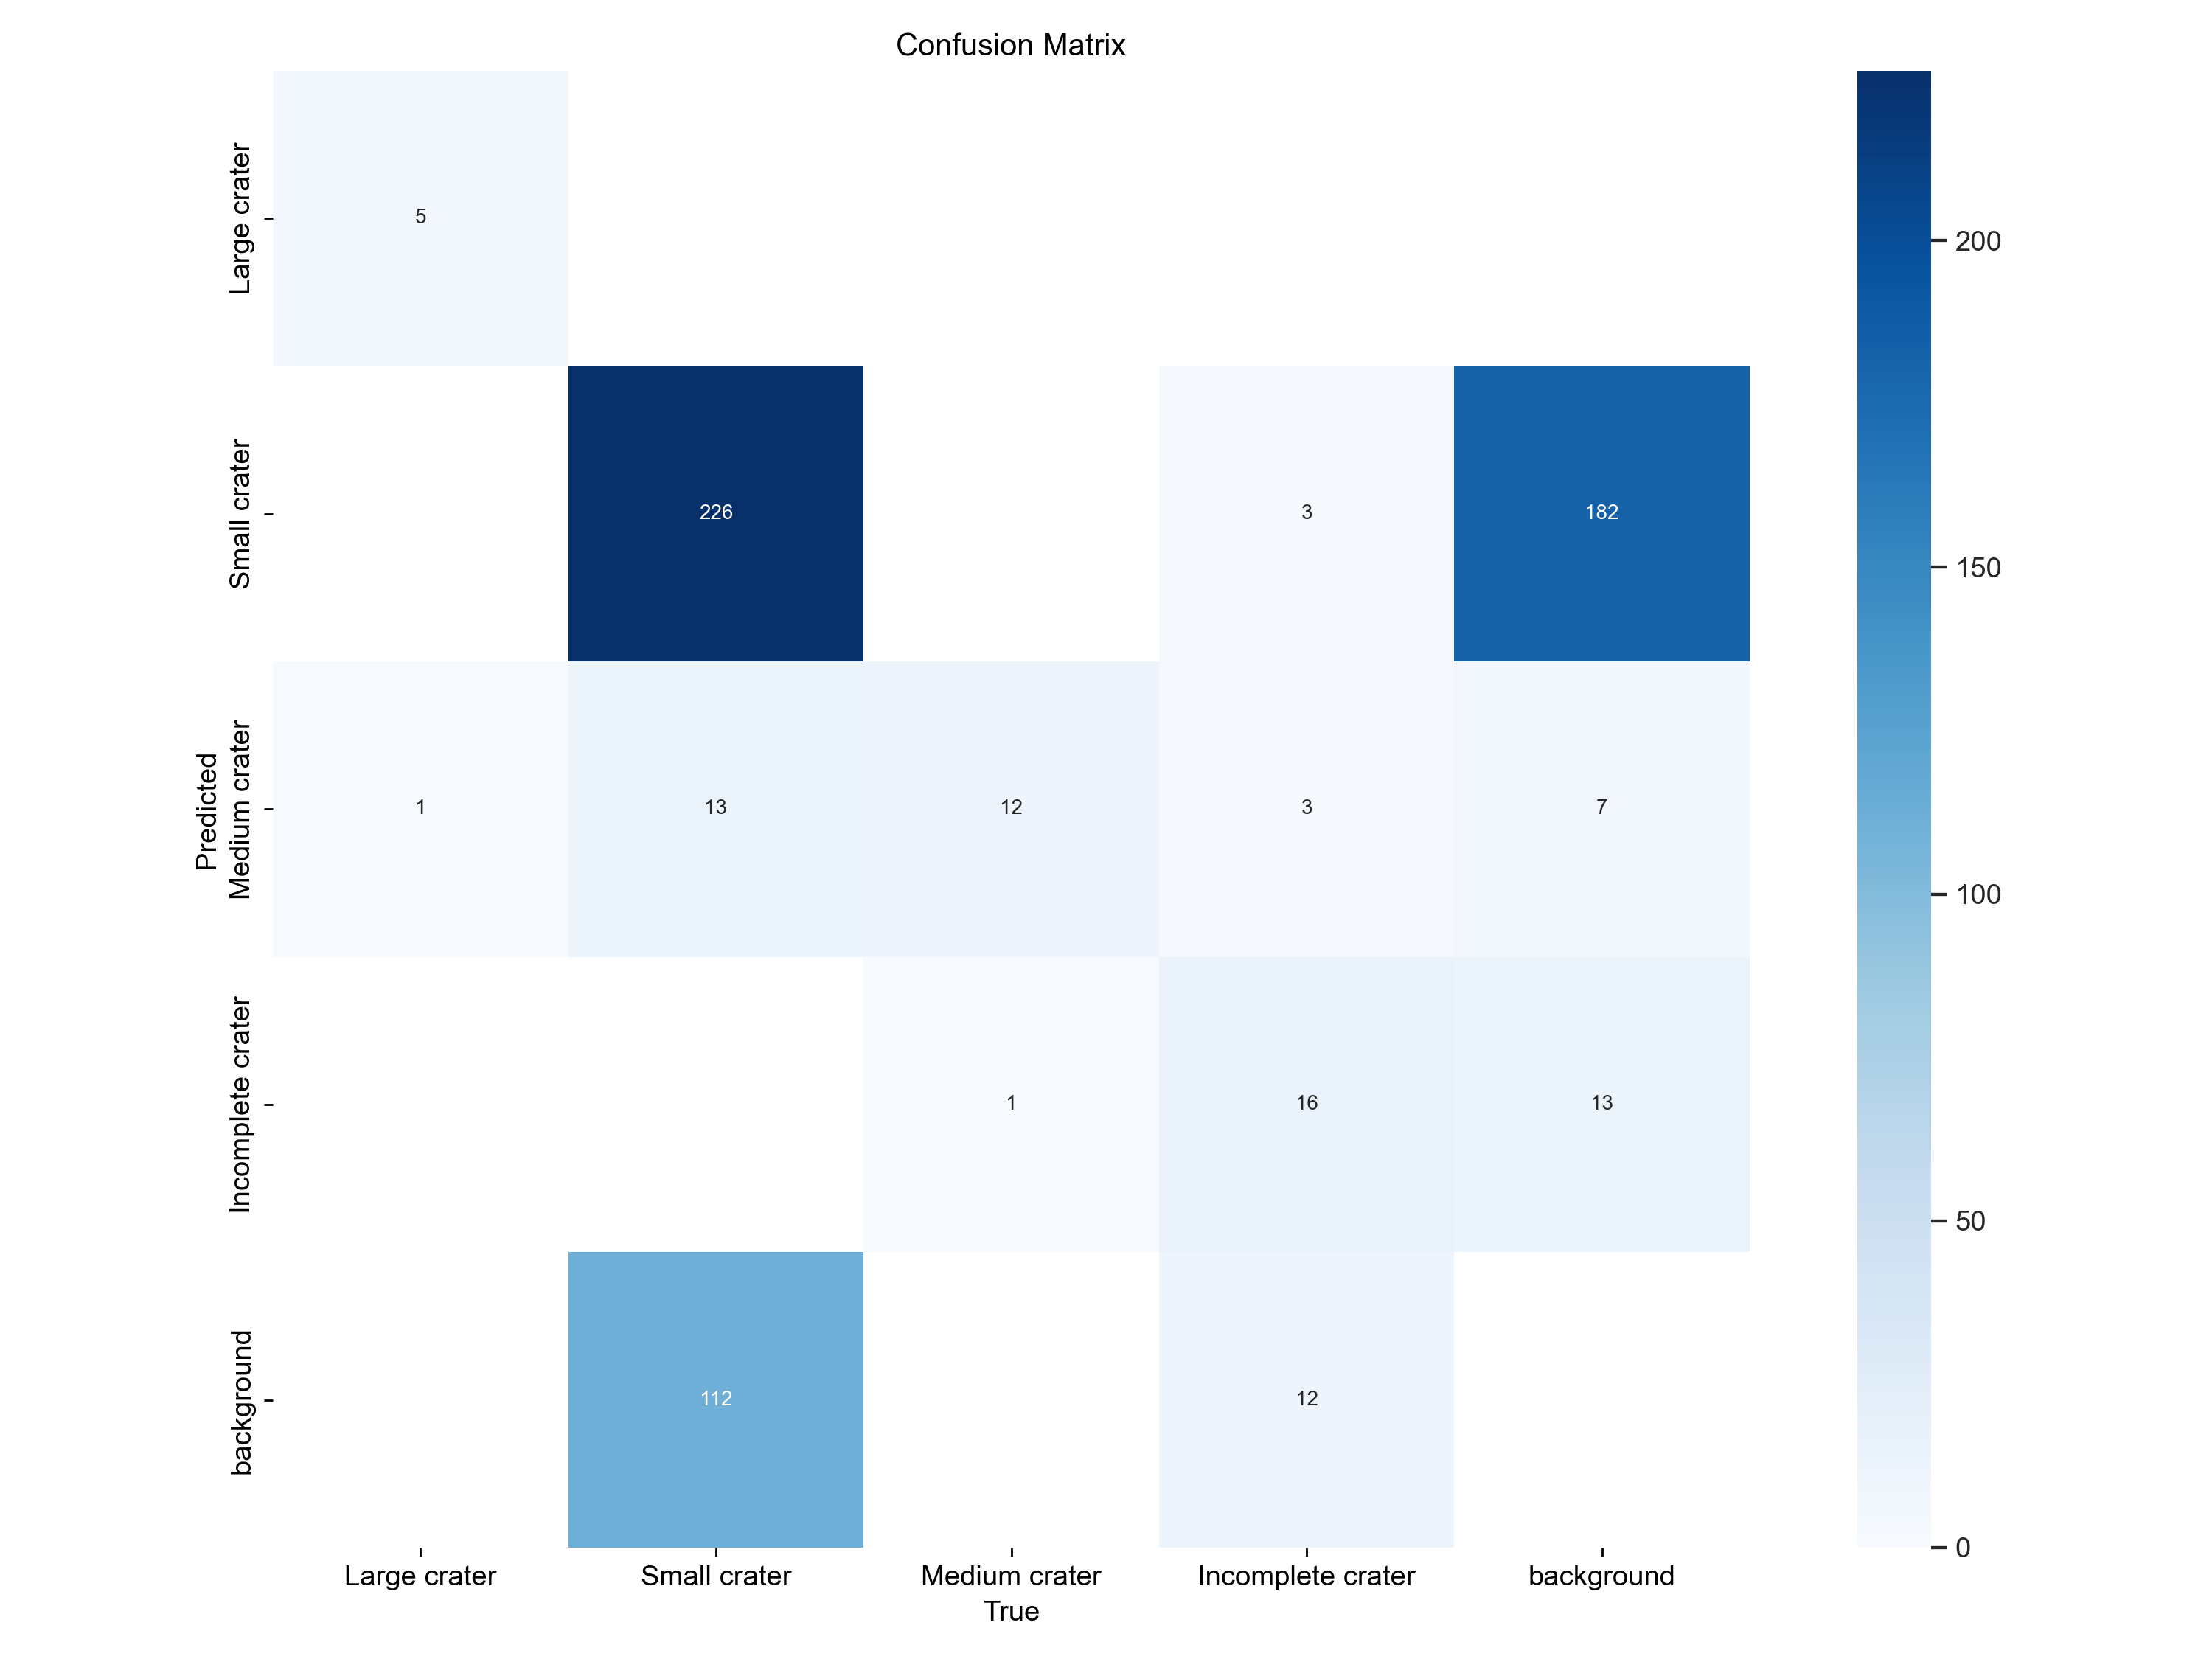

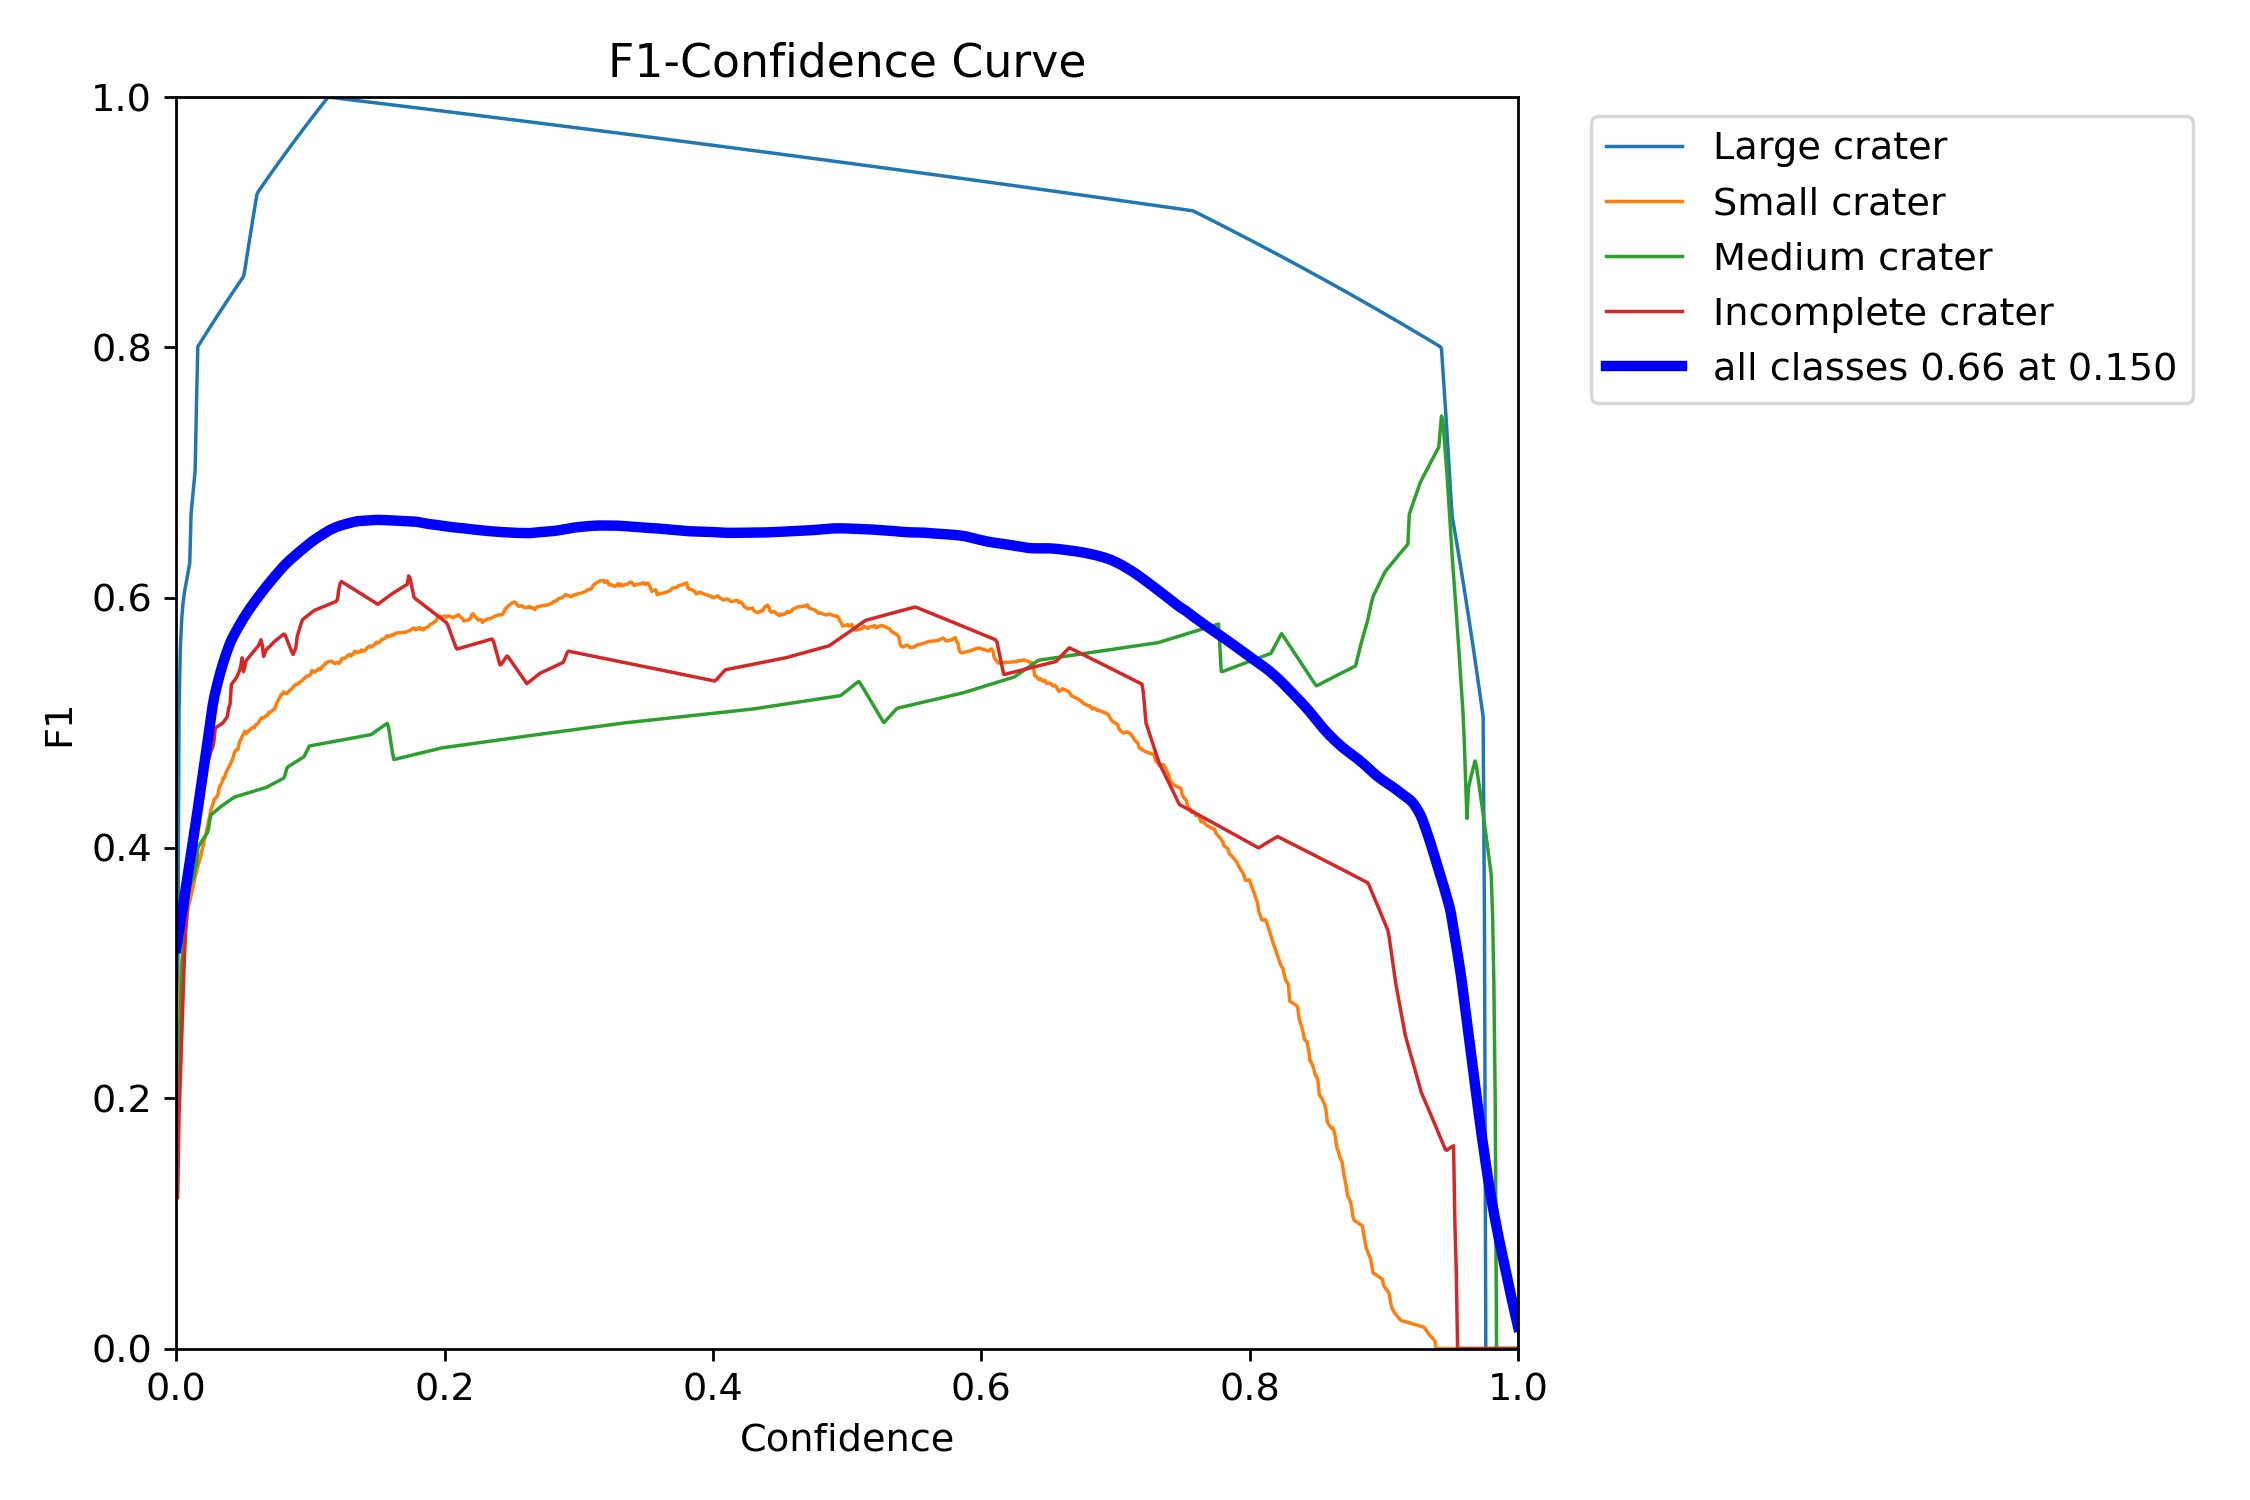

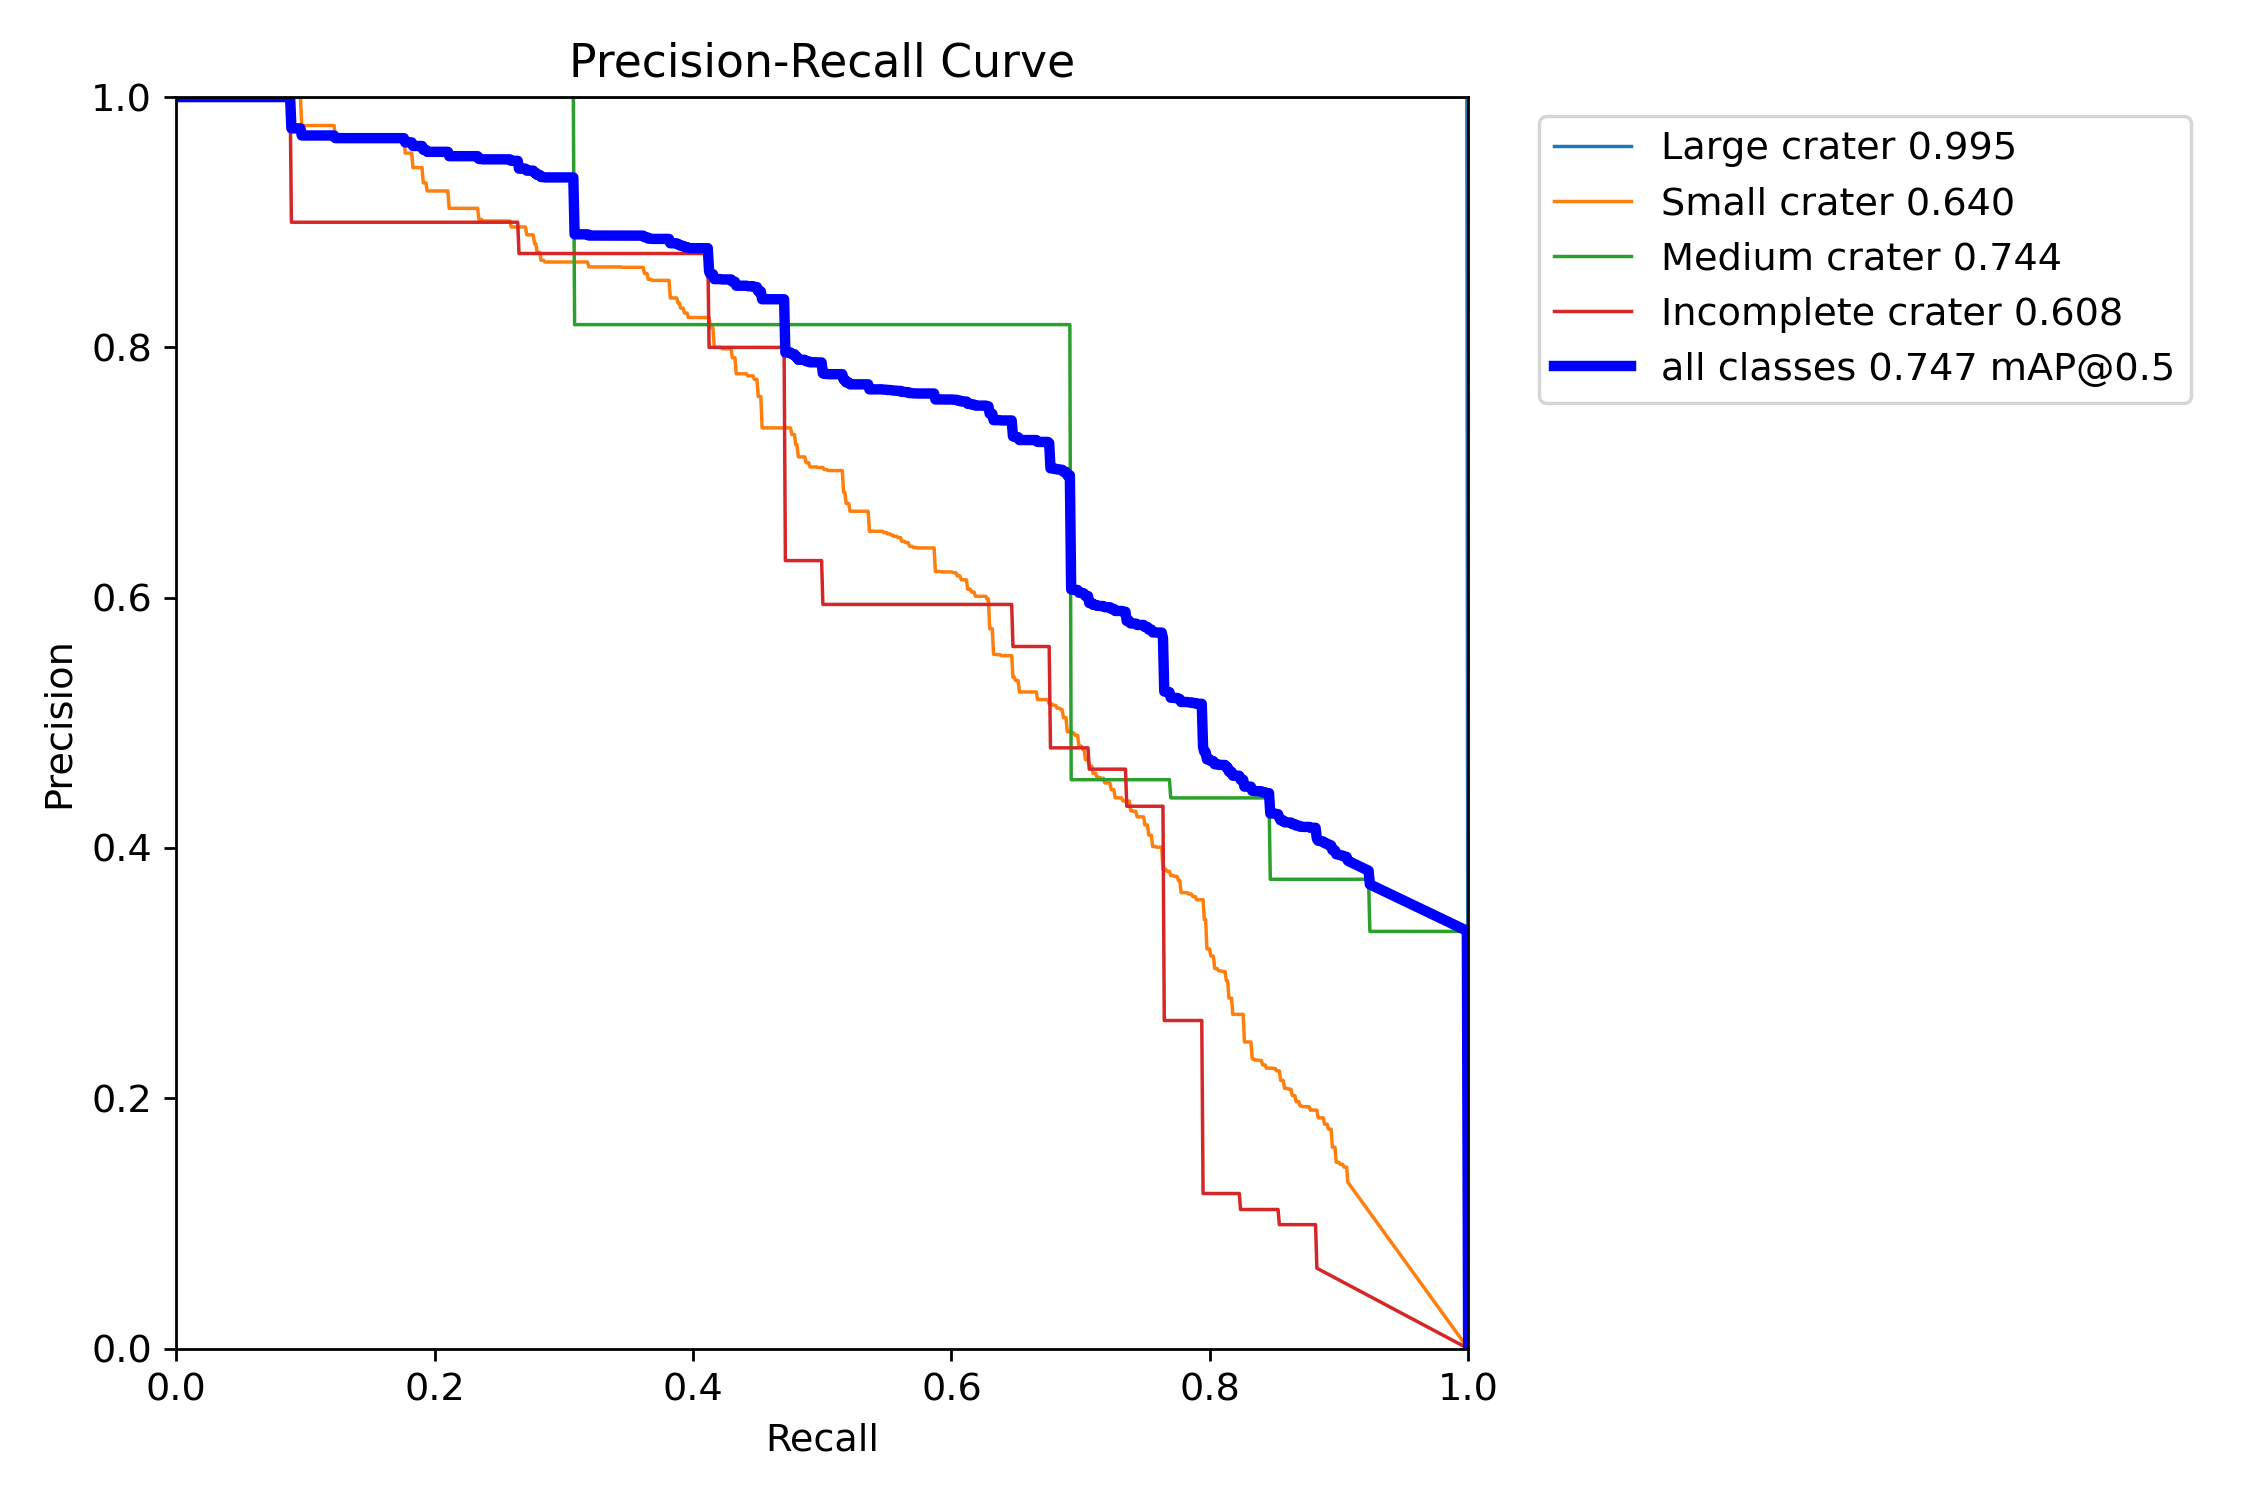

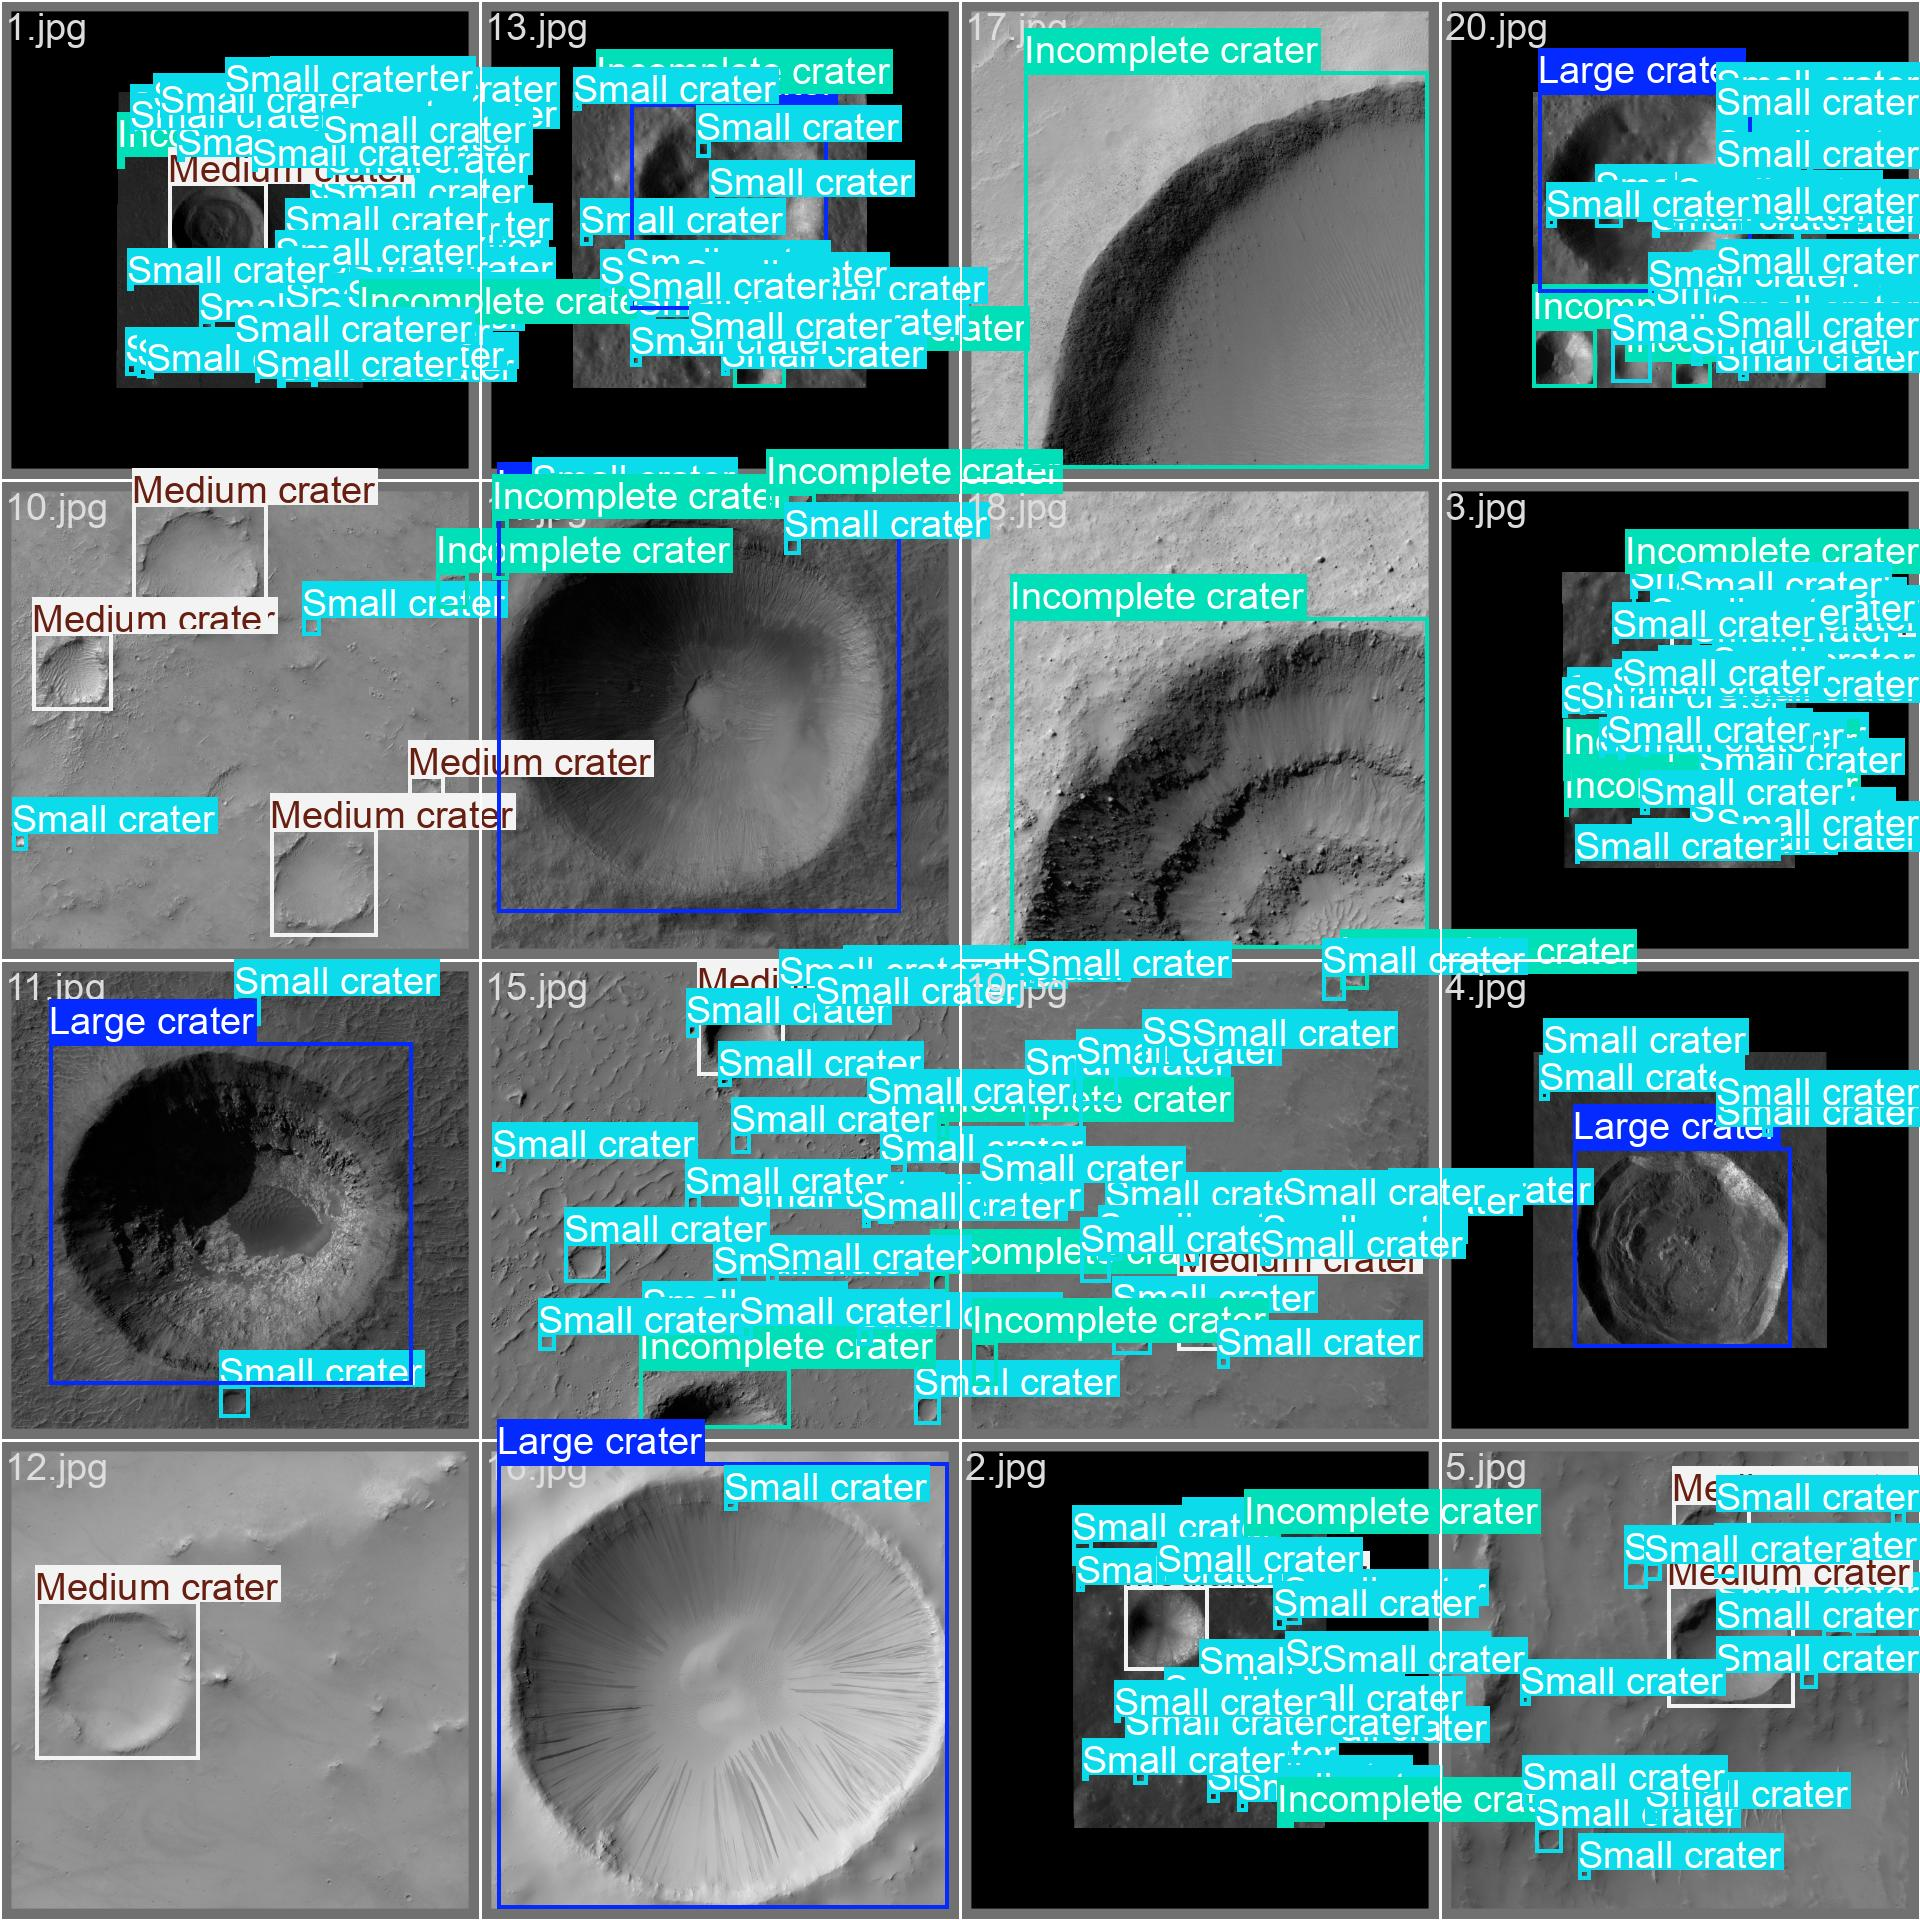

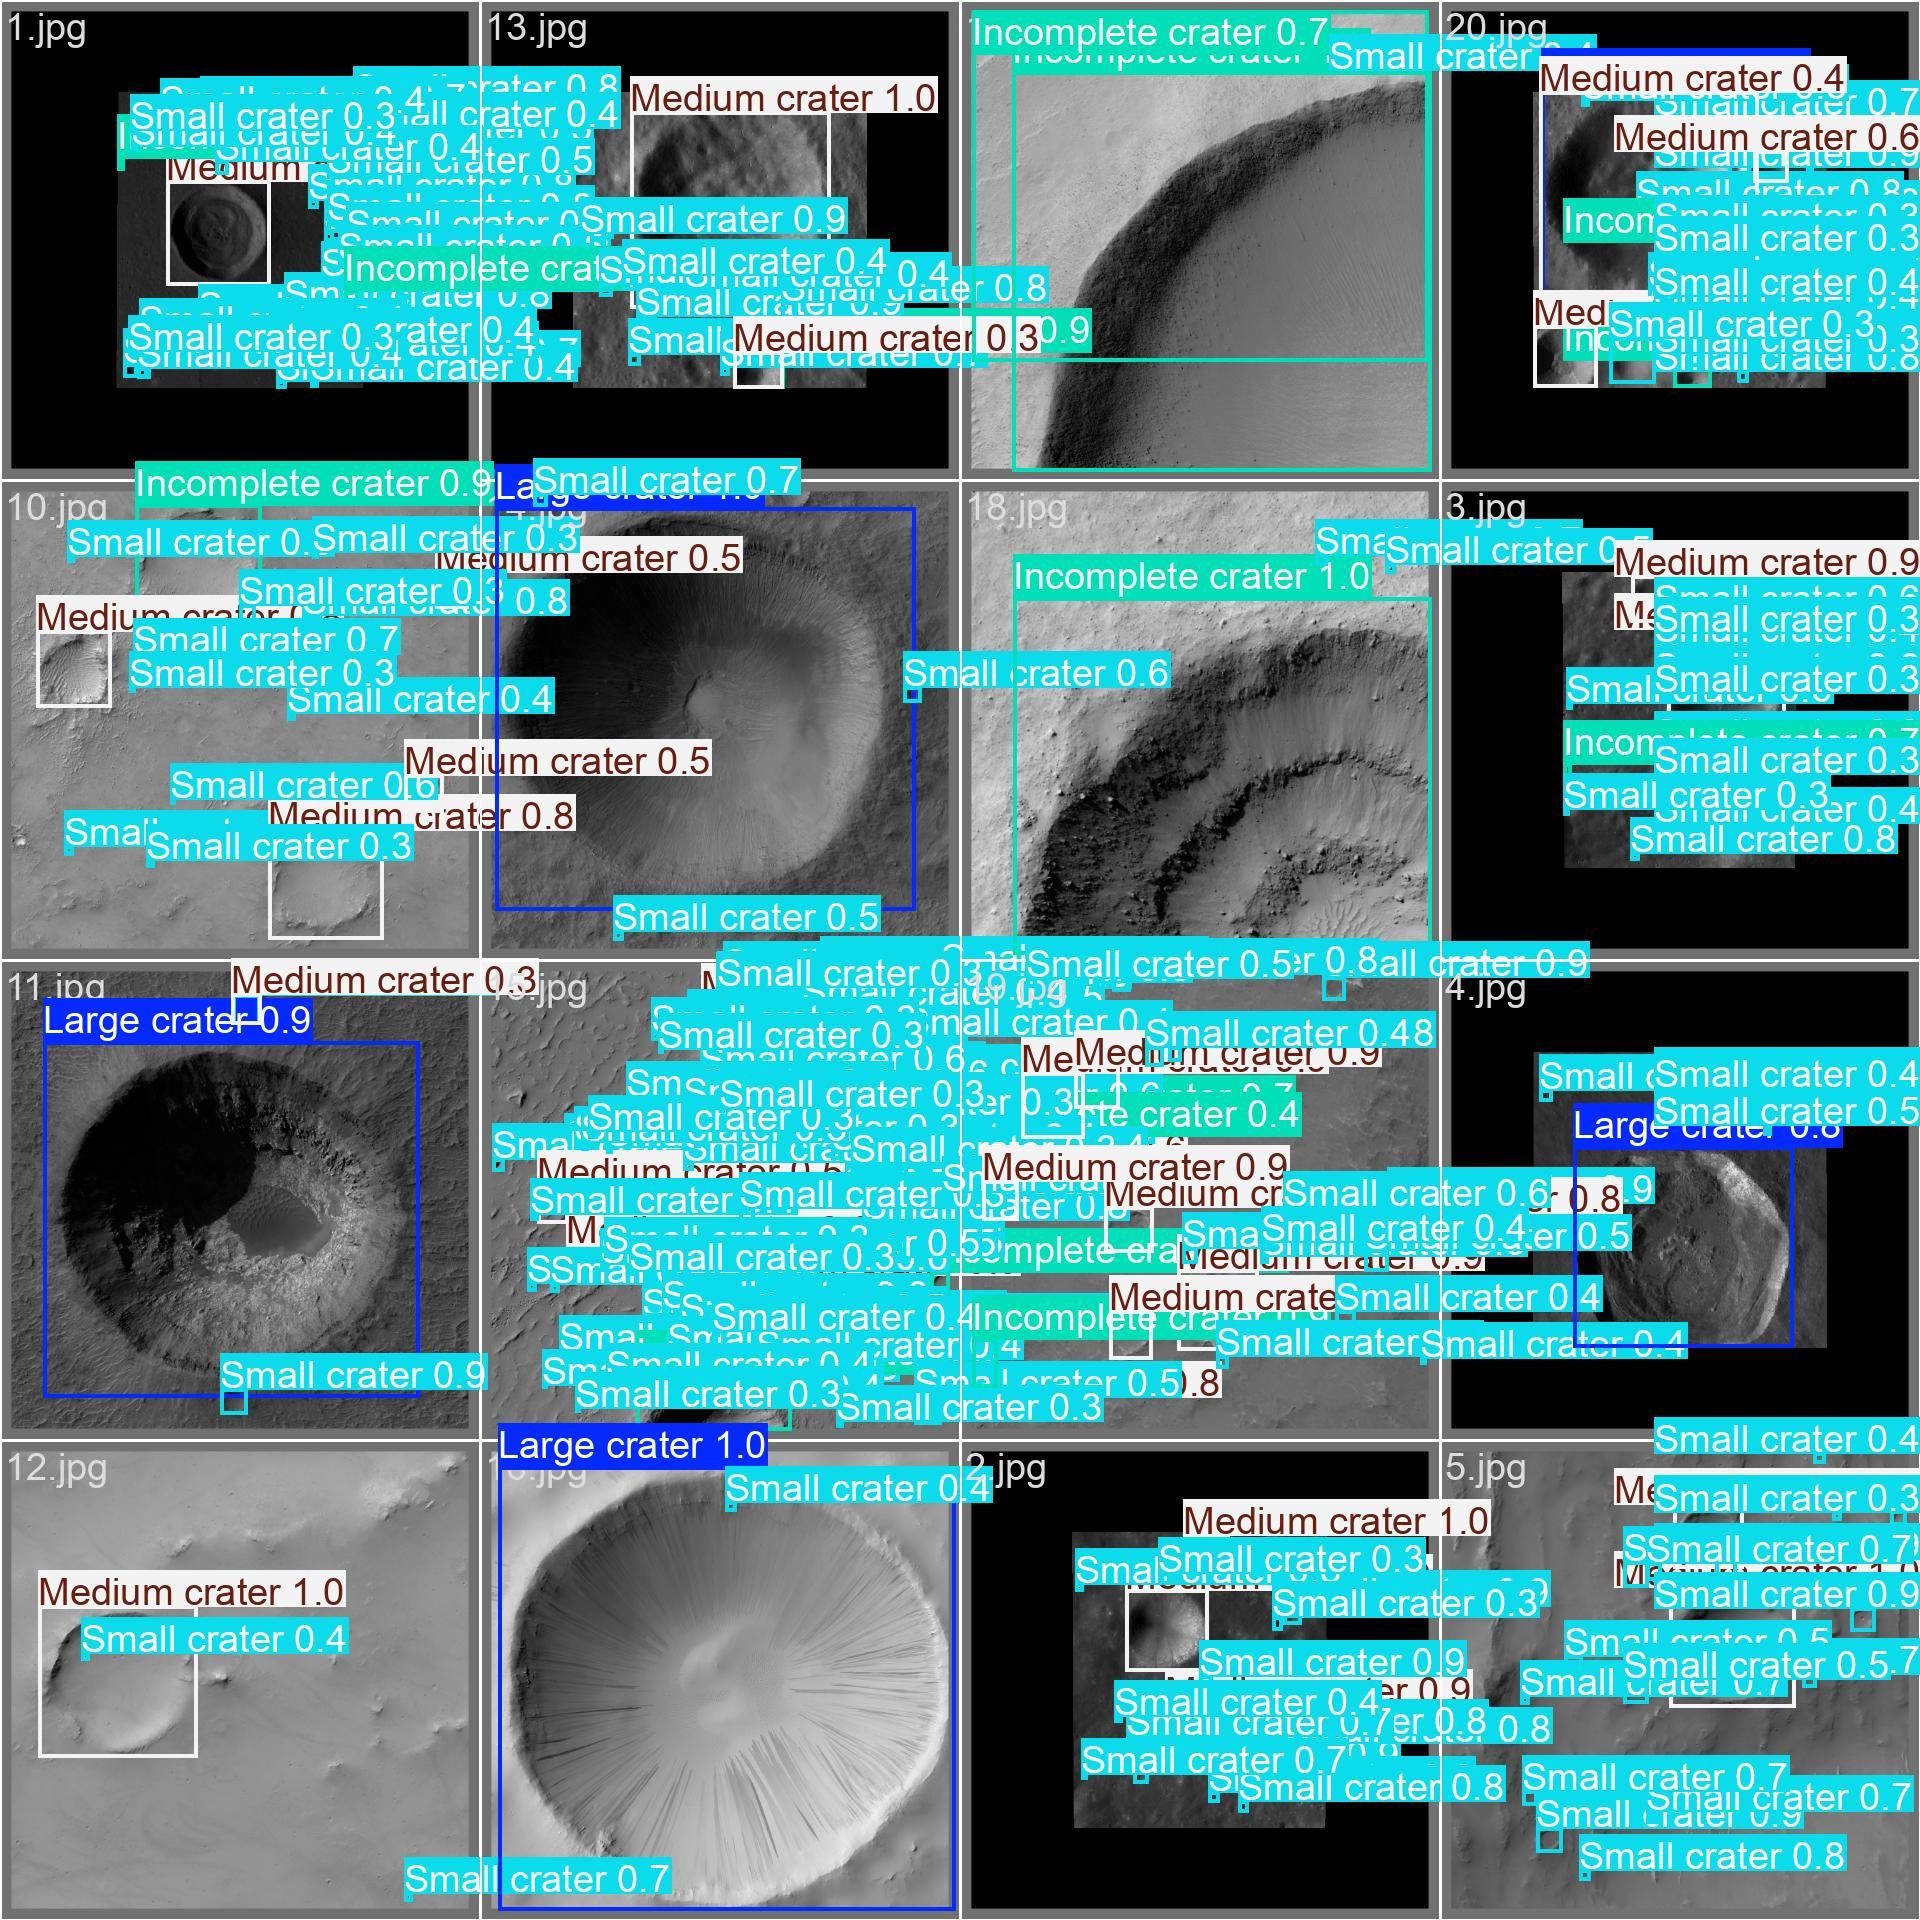

In [10]:
from IPython.display import Image, display
import os

result_dir = "runs/detect/train"
image_files = {
    "confusion matrix": "confusion_matrix.png",
    "F1 curve": "F1_curve.png",
    "PR curve": "PR_curve.png",
    "val labels": "val_batch0_labels.jpg",
    "val pred": "val_batch0_pred.jpg"
}

# 显示图片
for name, filename in image_files.items():
    img_path = os.path.join(result_dir, filename)
    if os.path.exists(img_path):
        display(Image(filename=img_path, width=600))
    else:
        print(f"not find files: {img_path}")
